In [1]:
### This notebook is for diagnosis of multilayer breaking wave. ###
import pandas as pd
import numpy as np
import math
import os
from matplotlib import pyplot as plt
import sys
from scipy.interpolate import griddata
from tqdm import tqdm
sys.path.append('/projects/DEIKE/jiarongw/jiarongw-postprocessing/jupyter_notebook/functions/')
from fio import readin
plt.style.use('/projects/DEIKE/jiarongw/jiarongw-postprocessing/media/matplotlib/stylelib/pof.mplstyle')
from fio import readin
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib as mpl

### Reference:
* [Normalizaton of fft](https://stackoverflow.com/questions/47268513/how-to-normalize-the-spectrum-of-a-numpy-real-fourier-transform-so-that-parcev)
* [Internal links to jupyter cells](https://github.com/jupyterlab/jupyterlab/issues/7054)

## Table of Contents:
#### [1. 3D FFT](#1)
#### [2. Time series of 2D spectrum](#2)
#### [3. Time series of 1D spectrum](#3)

In [2]:
""" Interpolate cartesian onto polar 
    Input: 
        xs, ys: x and y positions in cartesian coordinate, 1D arrays
        F_xy: functional value in cartesian coordinate corresponding to the xs and ys, 2D array
        ntheta, nr (optional): desired number of points in theta and r
    Output: 
        radii, thetas: r and theta (in randian) in polar coordinate, 1D arrays 
        F_rtheta: interpolated F in polar coordinate, 2D array
        """

""" Help functions """
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def make_r_theta_vals(xs,ys,F_xy,ntheta=100,nr=100):    
    rmax = (xs.max()**2 + ys.max()**2)**0.5
    radii = np.linspace(0, rmax, nr, endpoint=True)
    thetas = np.linspace(0, 2*np.pi, ntheta, endpoint=True)
    r_tile, theta_tile = np.meshgrid(radii, thetas)
    xp_tile, yp_tile = pol2cart(r_tile, theta_tile) # The xs and ys correponding to the POLAR radii and thetas
    x_tile, y_tile = np.meshgrid(xs, ys)
    F_rtheta = griddata((x_tile.ravel(), y_tile.ravel()), F_xy.ravel(), (xp_tile, yp_tile), method='nearest')
    return radii, thetas, F_rtheta

### <a class="anchor" id="1">3D FFT</a>

In [3]:
'''3D fft: read in data and store as 3D array, take the 500m box as an example '''
# filepath = '/projects/DEIKE/jiarongw/multilayer/field_new_500m_P0.05_RE40000_9_15_rand2_Htheta0.503/'
filepath='/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.03_RE40000_9_15_rand2_Htheta0.503/'
# filepath='/projects/DEIKE/jiarongw/multilayer/field_new_50m_P0.02_RE40000_9_15_rand2_Htheta0.503/'
# filepath='/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.8_RE40000_9_15_rand2_Htheta0.503_alter1/'
# filepath='/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.2_RE40000_9_15_rand2_Htheta0.503_alter2/'

N = 512
time = np.arange(60.1,120,0.1)
Nt = 512 # number of frames
eta_series = np.zeros((Nt,N,N), dtype=np.float32)
for i in range(0, Nt):
    filename = filepath + 'surface/eta_matrix_%g' %time[i]
    eta = np.fromfile(filename, dtype=np.float32)
    eta = eta.reshape(N+1,N+1); eta = eta[1:,1:]
    eta_series[i] = eta    
print(eta_series.shape)

(512, 512, 512)


In [4]:
data = eta_series

dt = 0.1    # sampling frequency, (Hz)
# L0 = 500.; N = 512 # Domain size and grid number in each direction
L0 = 200.; N = 512 # Domain size and grid number in each direction
# L0 = 50.; N = 512 # Domain size and grid number in each direction

dx = L0/N     # spatial sampling step along X in (m)
dy = L0/N      # spatial sampling step along Y in (m)
t_max = dt * data.shape[0]  # s
x_max = dx * data.shape[1]  # m
y_max = dy * data.shape[2]  # m
x = np.linspace(0, x_max, data.shape[1])   # m
y = np.linspace(0, y_max, data.shape[2])   # m
xx,yy = np.meshgrid(x, y, indexing='ij')
omega = np.linspace(-np.pi / dt, np.pi / dt, data.shape[0])                          # frequency (Hz)
kx = np.linspace(-np.pi / dx, np.pi / dx, data.shape[1])  # wavenumber along X axis (rad/mm)
ky = np.linspace(-np.pi / dy, np.pi / dy, data.shape[2])  # wavenumber along Y axis (rad/mm)
Ky, Kx = np.meshgrid(ky, kx, indexing='ij')
Omega, K = np.meshgrid(omega, kx, indexing='ij')

In [5]:
# Fourrier transform along Y, X and T axes to obtain ky, kx, f
dkx = kx[1]-kx[0]; dky = ky[1]-ky[0]; domega = omega[1]-omega[0]
spectrum_3d = np.fft.fftn(data) / (N*N*Nt)**0.5          
# Apply frequency shift along spatial dimentions 
# that zero-frequency component appears at the center of the spectrum
spectrum_3d = np.fft.fftshift(spectrum_3d, axes=(0,1,2))
F_3D = (np.absolute(spectrum_3d))**2 / N**2 / Nt / (dkx*dky*domega)

/tmp/ipykernel_160589/1305323345.py:16: RuntimeWarning: divide by zero encountered in log
  psd = plt.pcolormesh(omega[a:-a]/omegap, radii/kp, np.log(F_komega[:,a:-a]/np.max(F_komega[:,a:-a])), vmax=0, vmin=-10)


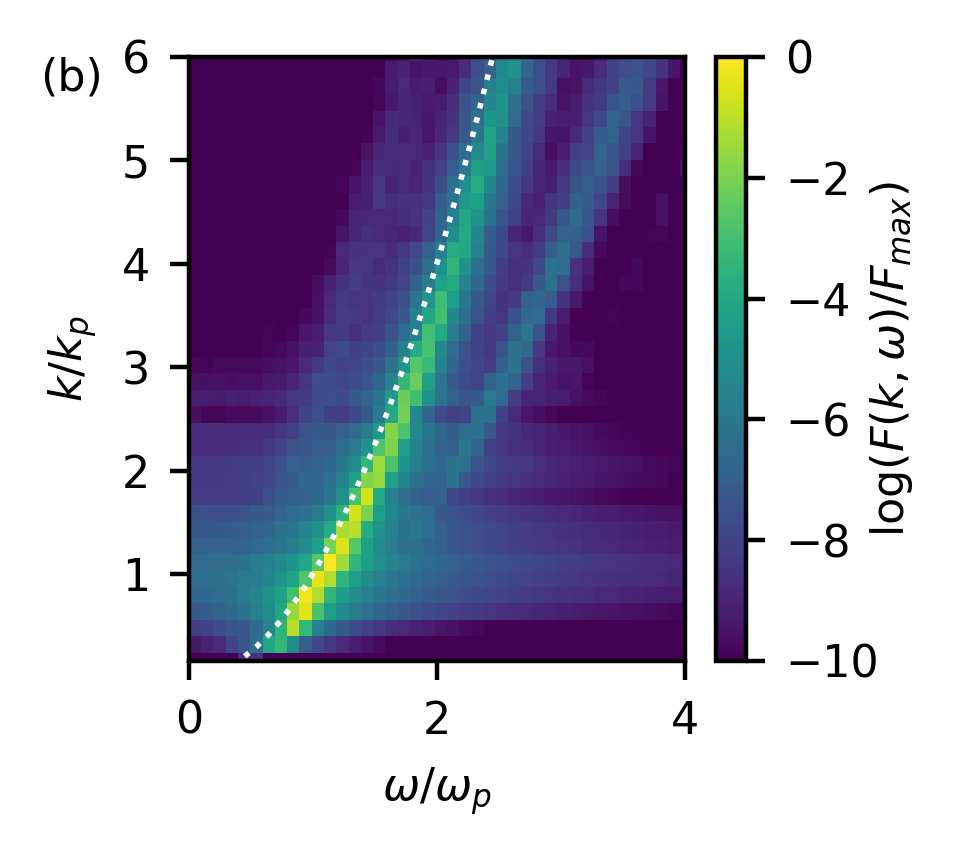

In [9]:
fig = plt.figure(figsize=[2,2]); ax = plt.gca()
# F_3D has dimension omega*kx*ky
F_komega = np.zeros((100, F_3D.shape[0])) # F_komega of dimension nr*omega
lim = 200
""" The make_r_theta_vals function has theta as axis 0 """
for i in range(0, F_3D.shape[0]):
    radii, thetas, F_rtheta = make_r_theta_vals(xs=kx[lim:-lim],ys=ky[lim:-lim],F_xy=F_3D[i][lim:-lim,lim:-lim],ntheta=100,nr=100) # F_rtheta is of dim nr*ntheta
    dtheta = thetas[1] - thetas[0]
    F_komega[:,i] = np.sum(F_rtheta*radii*dtheta, axis=0) # Azimuthal average  \int F(k,theta,omega)*k*dtheta

a = 200
# kp = 2*np.pi/100
kp = 2*np.pi/40
# kp = 2*np.pi/10
omegap = (kp*9.8)**0.5
psd = plt.pcolormesh(omega[a:-a]/omegap, radii/kp, np.log(F_komega[:,a:-a]/np.max(F_komega[:,a:-a])), vmax=0, vmin=-10)

plt.plot(omega[200:-200]/omegap, (omega[200:-200])**2/9.8/kp, ':', lw=1, c='w')
cbar = plt.colorbar(psd)
cbar.set_label(r'$\log(F(k,\omega)/F_{max}) $', labelpad=-2)

plt.xlabel('$\omega/\omega_p$')
plt.ylabel('$k/k_p$')

ax.set_ylim([radii[1]/kp,6])
ax.set_xlim([0,4])
ax.text(-0.3, 1.0, '(b)', transform=ax.transAxes, fontsize='medium', verticalalignment='top')

# fig.savefig('figures/dispersion_500m.pdf', bbox_inches='tight', pad_inches=0)
# fig.savefig('figures/dispersion_200m_colorbar.pdf', bbox_inches='tight', pad_inches=0)
fig.savefig('figures_vector/dispersion_200m_colorbar.eps', bbox_inches='tight', pad_inches=0)
# fig.savefig('figures/dispersion_50m.pdf', bbox_inches='tight', pad_inches=0)
# plt.plot(omega[a:300], omega[a:300]**2/9.8, '--', 'w', color='w')

/tmp/ipykernel_8482/1286777326.py:16: RuntimeWarning: divide by zero encountered in log
  psd = plt.pcolormesh(omega[a:-a]/omegap, radii/kp, np.log(F_komega[:,a:-a]))


(0.0, 2.0)

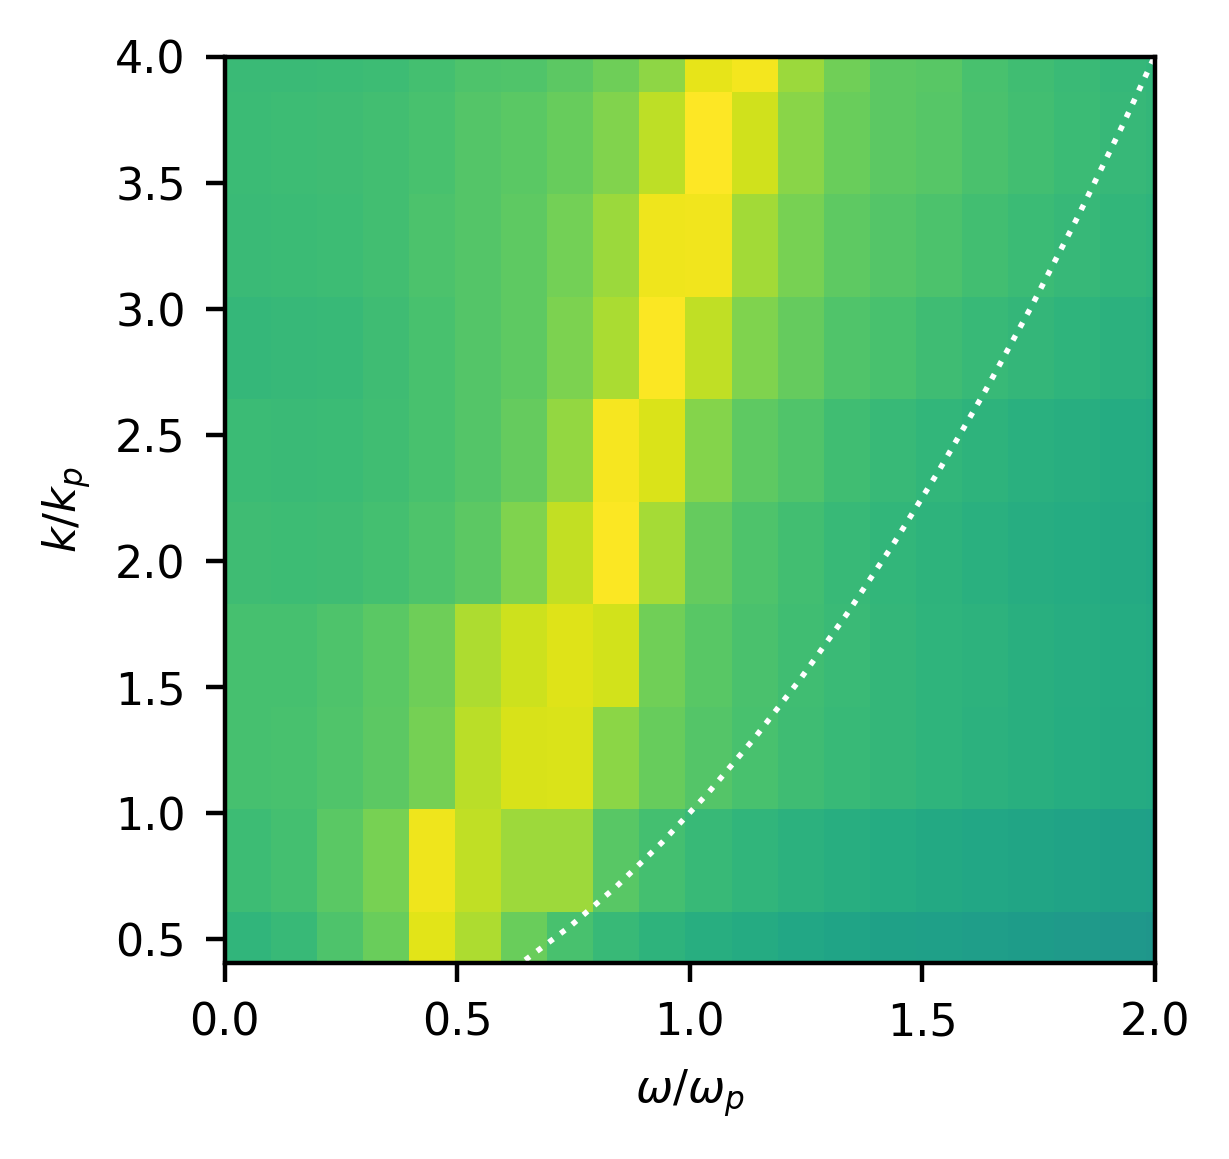

In [8]:
fig = plt.figure(figsize=[3,3]); ax = plt.gca()
# F_3D has dimension omega*kx*ky
F_komega = np.zeros((100, F_3D.shape[0])) # F_komega of dimension nr*omega
lim = 220
""" The make_r_theta_vals function has theta as axis 0 """
for i in range(0, F_3D.shape[0]):
    radii, thetas, F_rtheta = make_r_theta_vals(xs=kx[lim:-lim],ys=ky[lim:-lim],F_xy=F_3D[i][lim:-lim,lim:-lim],ntheta=100,nr=100) # F_rtheta is of dim nr*ntheta
    dtheta = thetas[1] - thetas[0]
    F_komega[:,i] = np.sum(F_rtheta*radii*dtheta, axis=0) # Azimuthal average  \int F(k,theta,omega)*k*dtheta

a = 206
# kp = 2*np.pi/100
kp = 2*np.pi/40
# kp = 2*np.pi/10
omegap = (kp*9.8)**0.5
psd = plt.pcolormesh(omega[a:-a]/omegap, radii/kp, np.log(F_komega[:,a:-a]))

plt.plot(omega[240:-200]/omegap, (omega[240:-200])**2/9.8/kp, ':', lw=1, c='w')

plt.xlabel('$\omega/\omega_p$')
plt.ylabel('$k/k_p$')

ax.set_ylim([radii[1]/kp,4])
ax.set_xlim([0,2])
# fig.savefig('figures/dispersion_500m.pdf', bbox_inches='tight', pad_inches=0)
# fig.savefig('figures/dispersion_200m.pdf', bbox_inches='tight', pad_inches=0)
# fig.savefig('figures/dispersion_50m.pdf', bbox_inches='tight', pad_inches=0)
# plt.plot(omega[a:300], omega[a:300]**2/9.8, '--', 'w', color='w')

/tmp/ipykernel_40841/2310053310.py:39: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  img = ax.pcolormesh(thetas, radii, np.rot90(F_rtheta)[::-1,:], edgecolors='white', lw=0.1, cmap='PuRd', vmax=vmax, vmin=vmin)


<Figure size 1600x1600 with 0 Axes>

findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


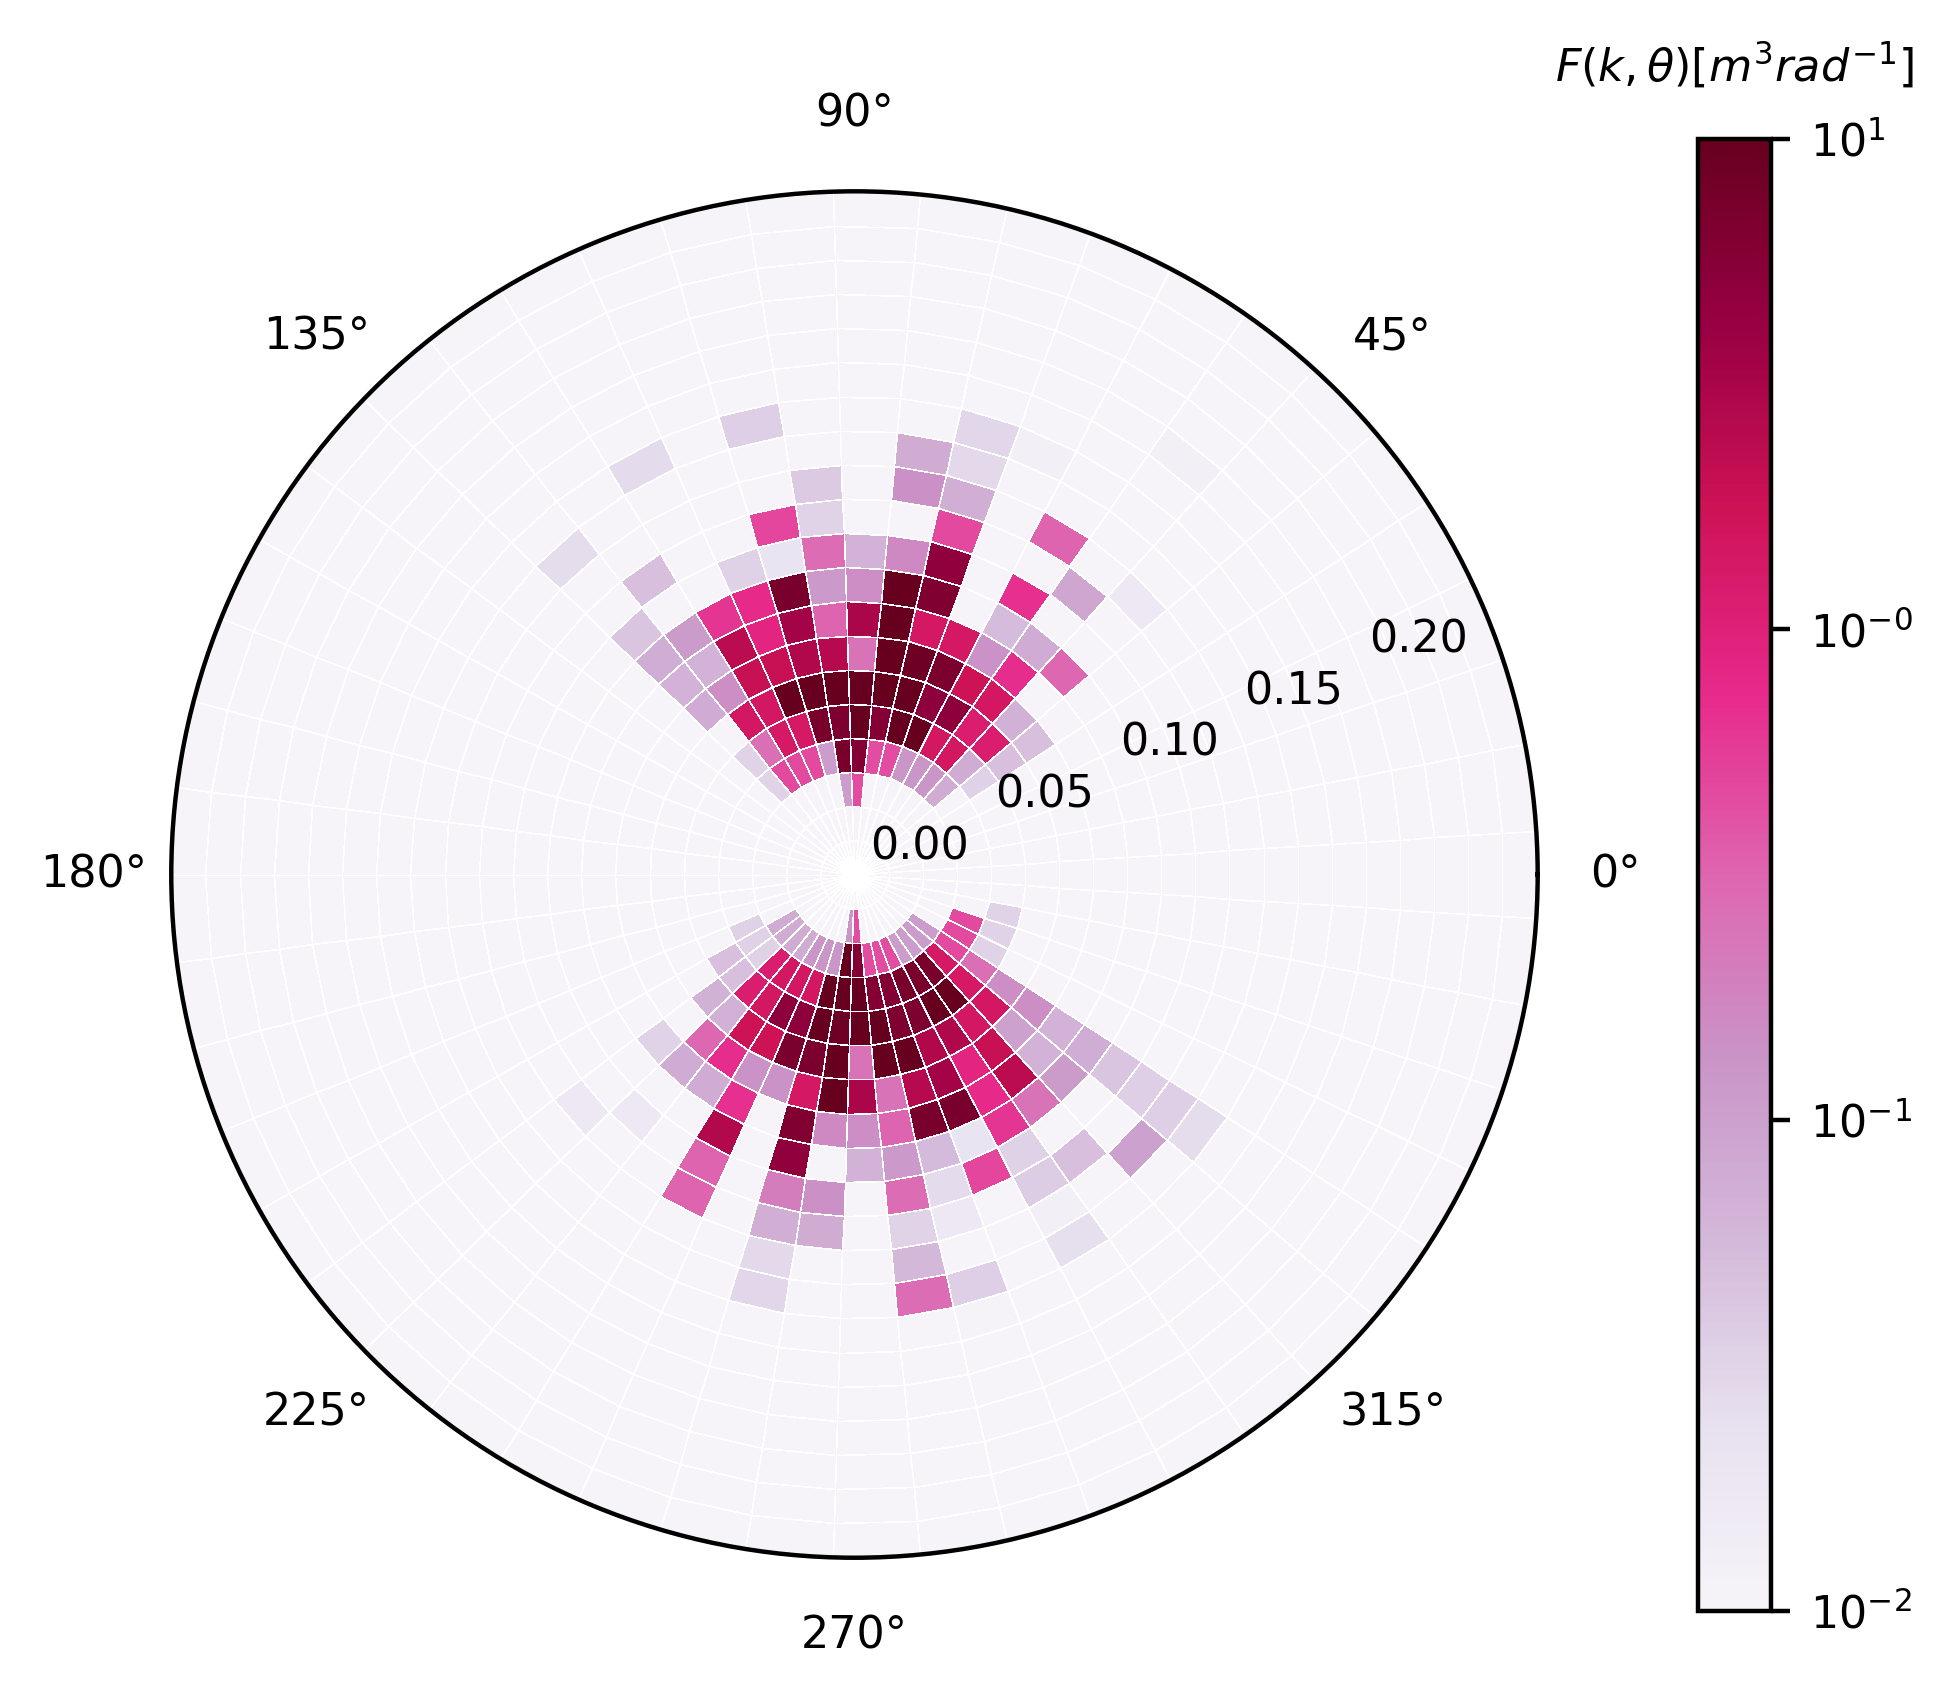

In [10]:
""" Notice: plt.imshow and plt.pcolormesh seem to plot opposite in the first axis!!!! """

""" Plot the polar spectrum 
    TODO: adjust the range and labeling when needed! """
def make_polar_plot(thetas, radii, F_rtheta):
    plt.clf()
    fig = plt.figure(figsize=[5,5])
    ax = fig.add_axes([0.1,0.1,0.8,0.8],polar=True)
    vmax=1; vmin=-2
    img = ax.pcolormesh(thetas, radii, np.rot90(F_rtheta)[::-1,:], edgecolors='white', lw=0.1, cmap='PuRd', vmax=vmax, vmin=vmin)
    cbar = fig.colorbar(img, orientation="vertical", fraction=0.046, pad=0.1, ticks=[-2,-1,0,1])
    cbar.ax.set_yticklabels(['$10^{-2}$','$10^{-1}$','$10^{-0}$','$10^{1}$'])
    cbar.ax.text(0.5, 1.05, r'$F(k,\theta) [m^3 rad^{-1}]$', ha='center', va='center', transform=cbar.ax.transAxes)


def make_cartesian_plot(xs, ys, F_xy):
    plt.clf()
    fig = plt.figure(figsize=[5,5])
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    ax.pcolormesh(xs, ys, F_xy, edgecolors='face')

lim = 242
radii, thetas, F_rtheta = make_r_theta_vals(xs=kx[lim:-lim],ys=ky[lim:-lim],F_xy=np.average(F_3D[:,lim:-lim,lim:-lim],axis=0),ntheta=50,nr=20)
make_polar_plot(thetas, radii, np.log(F_rtheta))
# make_cartesian_plot(xs=kx,ys=ky,F_xy=F[100])

<a id=’section_2’></a>

### <a class="anchor" id="2">Time sequence of 2D FFT (kx,ky)</a>

In [158]:
dt = 0.1    # sampling frequency, (Hz)
L0 = 500.; N = 512 # Domain size and grid number in each direction
dx = L0/N     # spatial sampling step along X in (m)
dy = L0/N      # spatial sampling step along Y in (m)
t_max = dt * data.shape[0]  # s
x_max = dx * data.shape[1]  # m
y_max = dy * data.shape[2]  # m
x = np.linspace(0, x_max, data.shape[1])   # m
y = np.linspace(0, y_max, data.shape[2])   # m
xx,yy = np.meshgrid(x, y, indexing='ij')
omega = np.linspace(-np.pi / dt, np.pi / dt, data.shape[0])                          # frequency (Hz)
kx = np.linspace(-np.pi / dx, np.pi / dx, data.shape[1])  # wavenumber along X axis (rad/mm)
ky = np.linspace(-np.pi / dy, np.pi / dy, data.shape[2])  # wavenumber along Y axis (rad/mm)
Ky, Kx = np.meshgrid(ky, kx, indexing='ij')
Omega, K = np.meshgrid(omega, kx, indexing='ij')

In [159]:
time = np.arange(0,60,0.1)
Nt = 512
spectrum_2d_series = np.zeros((Nt,N,N), dtype=np.float32)
for i in range(0, Nt):
    filename = filepath + 'surface/eta_matrix_%g' %time[i]
    eta = np.fromfile(filename, dtype=np.float32)
    eta = eta.reshape(N+1,N+1); eta = eta[1:,1:]
    spectrum = np.fft.fft2(eta) / (N*N)**0.5 # Shouldn't need to divide by Nt?
    F = np.absolute(spectrum)**2 / N**2 / (dkx*dky)
    F_center = np.fft.fftshift(F, axes=(0,1))
    spectrum_2d_series[i] = F_center

In [117]:
""" CHECK: the normalization of FFT """
dkx = kx[1]-kx[0]; dky = ky[1]-ky[0]
L0 = 500

filename = filepath + 'surface/eta_matrix_%g' %65
eta = np.fromfile(filename, dtype=np.float32)
eta = eta.reshape(N+1,N+1); eta = eta[1:,1:]
print(np.var(eta)) # Variance is already squared 
spectrum = np.fft.fft2(eta) / (N*N)**0.5 # Normalization of FFT
F = np.absolute(spectrum)**2 / N**2 / (dkx*dky) # Further normalize to get variance per area, and according to the dimension of the independent variables
F_center = np.fft.fftshift(F, axes=(0,1))
print(np.sum(F_center)*dkx*dky)

2.1893294
2.1893293083114496


<Figure size 1600x1600 with 0 Axes>

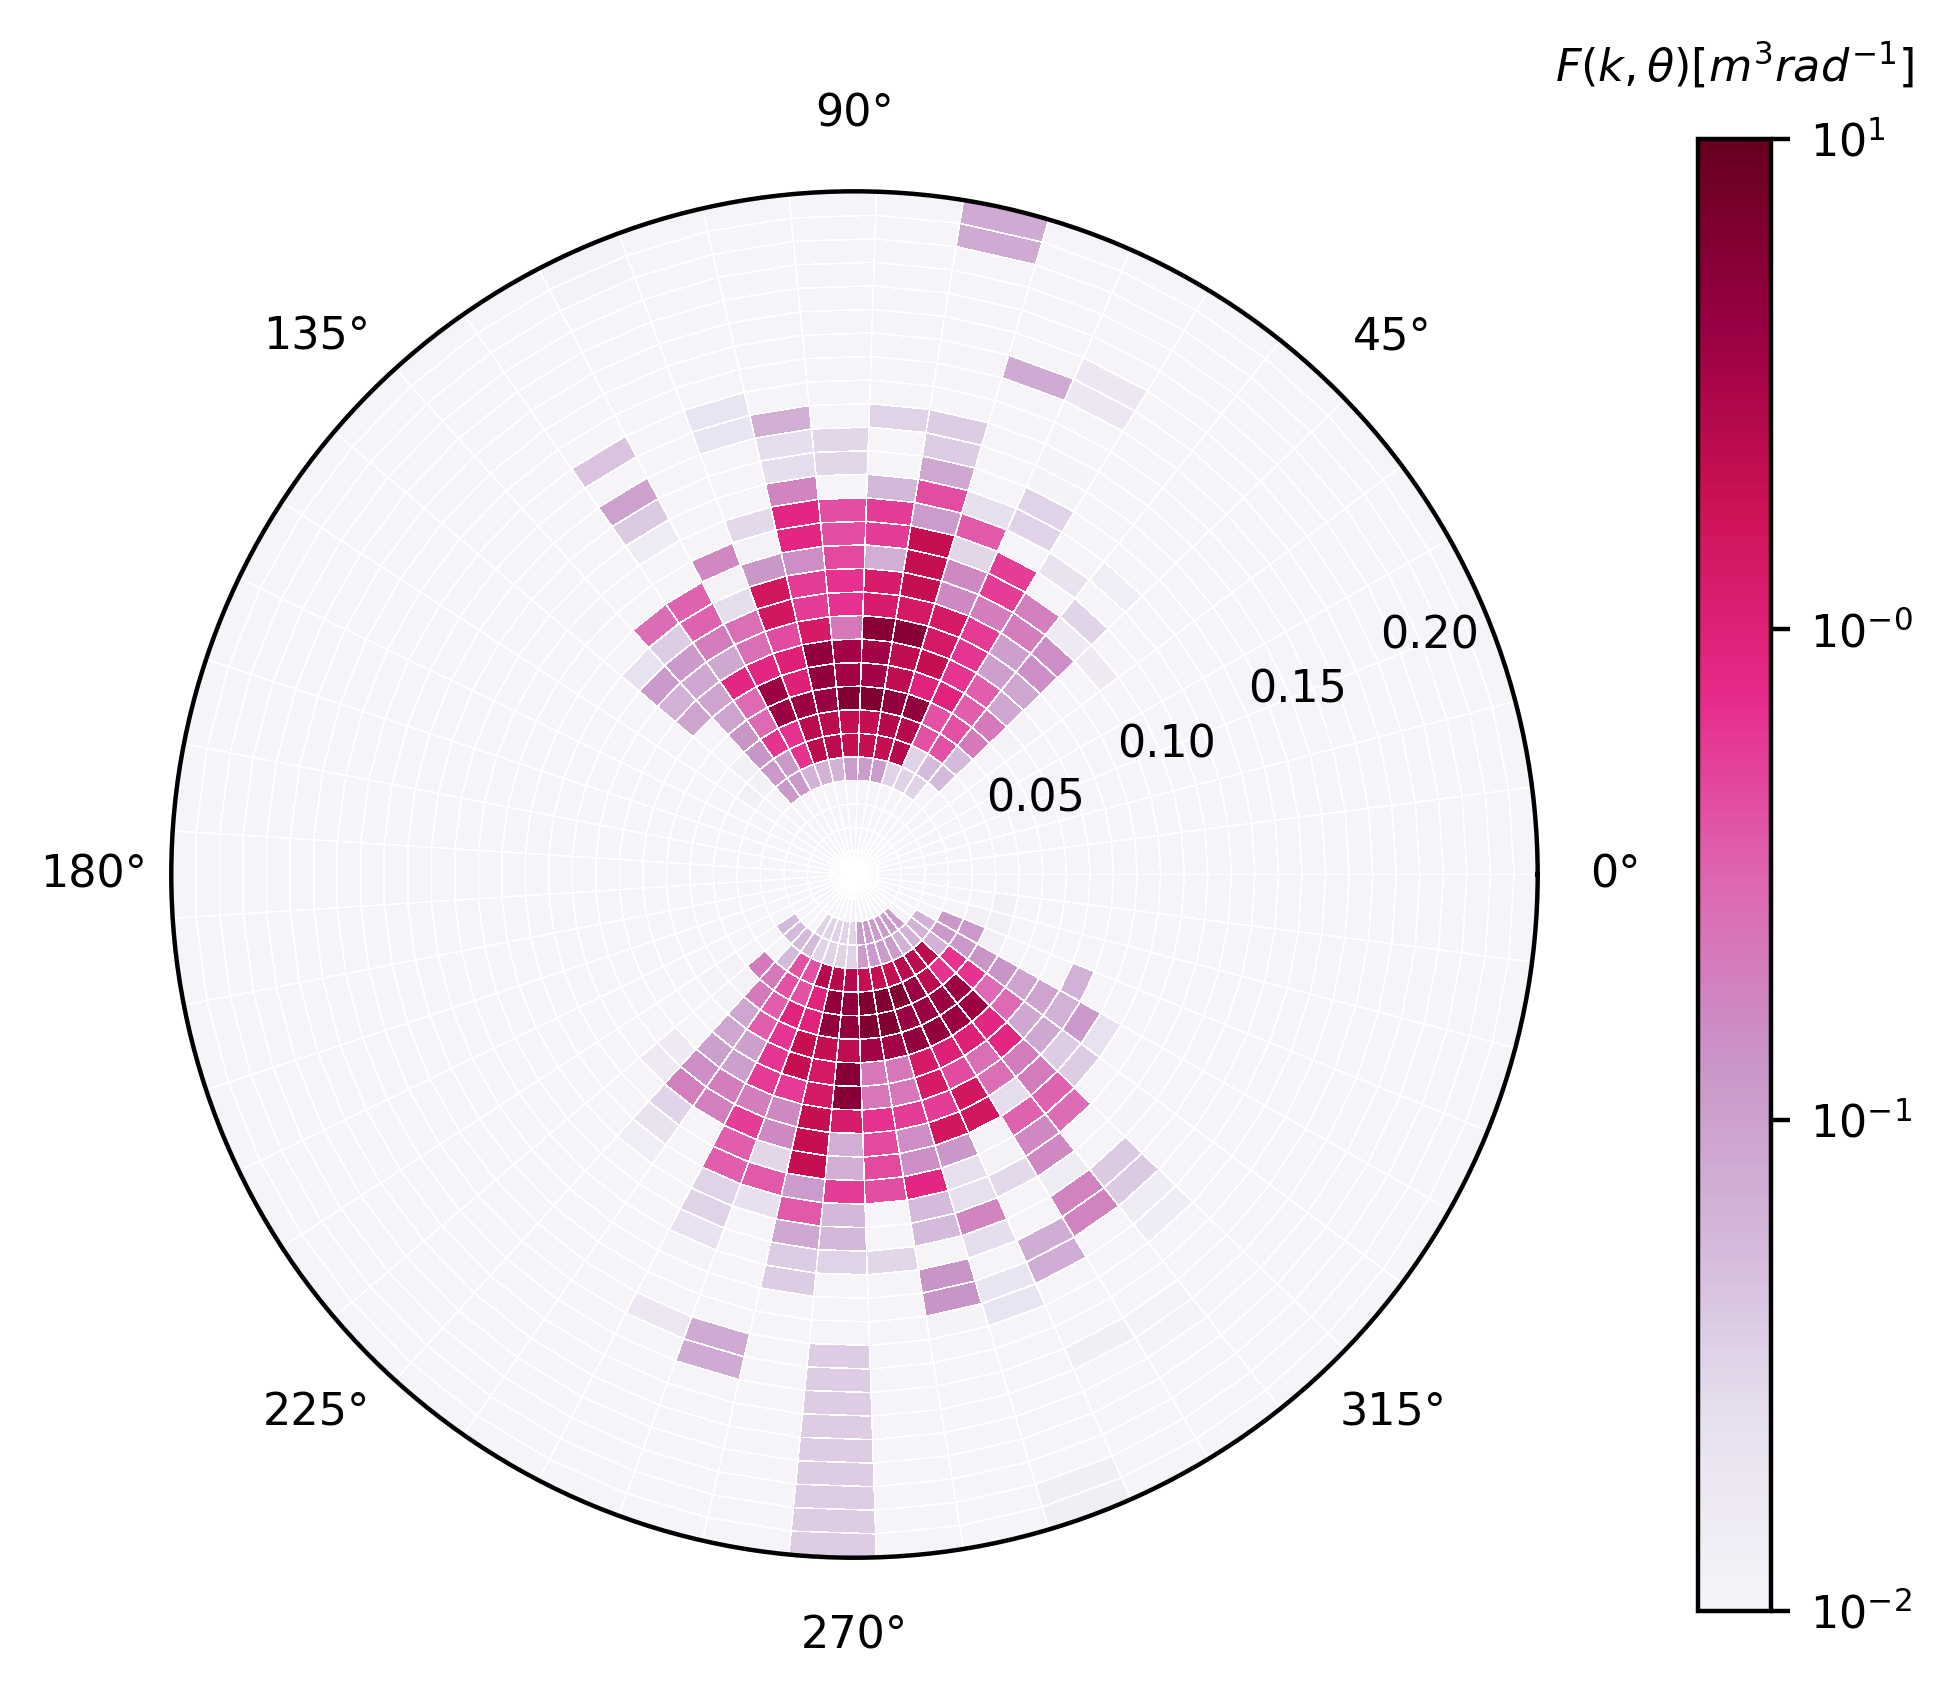

In [162]:
def make_polar_plot(thetas, radii, F_rtheta):
    plt.clf()
    fig = plt.figure(figsize=[5,5])
    ax = fig.add_axes([0.1,0.1,0.8,0.8],polar=True)
    vmax=1; vmin=-2
    img = ax.pcolormesh(thetas, radii, np.rot90(F_rtheta)[::-1,:], edgecolors='white', lw=0.1, cmap='PuRd', vmax=vmax, vmin=vmin) # F_rtheta axis0: increasing thetas, axis1: increasing radii
    cbar = fig.colorbar(img, orientation="vertical", fraction=0.046, pad=0.1, ticks=[-2,-1,0,1])
    cbar.ax.set_yticklabels(['$10^{-2}$','$10^{-1}$','$10^{-0}$','$10^{1}$'])
    cbar.ax.text(0.5, 1.05, r'$F(k,\theta) [m^3 rad^{-1}]$', ha='center', va='center', transform=cbar.ax.transAxes)
    
lim = 242
radii, thetas, F_rtheta = make_r_theta_vals(xs=kx[lim:-lim],ys=ky[lim:-lim],F_xy=spectrum_2d_series[200][lim:-lim,lim:-lim],ntheta=50,nr=30)
make_polar_plot(thetas, radii, np.log(F_rtheta))

### <a class="anchor" id="3">Time sequence of 1D spectrum</a>

In [11]:
from scipy.interpolate import LinearNDInterpolator, griddata
def spectrum_integration(eta, L, N, CHECK=False):
    """ This function performs azimuthal integration of the 2D spectrum (Notice it's 2D instead of 3D with the frequency as well).
        When in doubt, enable CHECK so that the integration is printed out at each step to make sure that 
        units are consistent and we always recover the variance of the data. """  
    if CHECK: print (np.var(eta))
    spectrum = np.fft.fft2(eta) / (N*N)**0.5 # FFT normalization 
    F = np.absolute(spectrum)**2 / N**2 # Per area normalization
    if CHECK: print (np.sum(F))
    wavenumber = 2*np.pi*np.fft.fftfreq(n=N,d=L/N)
    kx = np.fft.fftshift(wavenumber); ky = kx
    kx_tile, ky_tile = np.meshgrid(kx,ky)
    theta = np.arange(-N/2,N/2)/(N)*2*np.pi
    k = wavenumber[0:int(N/2)]
    dkx = kx[1] - kx[0]; dky = ky[1] - ky[0]
    dk = k[1]-k[0]; dtheta = theta[1]-theta[0]
    F_center = np.fft.fftshift(F)/dkx/dky # Further normalization by independent variables
    k_tile, theta_tile = np.meshgrid(k,theta)
    kxp_tile, kyp_tile = pol2cart(k_tile, theta_tile)
    F_center_polar = griddata((kx_tile.ravel(),ky_tile.ravel()), F_center.ravel(), (kxp_tile, kyp_tile), method='nearest')
    F_center_polar_integrated = np.sum(F_center_polar*k_tile, axis=0)*dtheta # Azimuthal integration
    if CHECK: print (np.sum(F_center_polar_integrated)*dk)
    return F_center_polar_integrated

kp=0.15708, omegap=1.24072
0.22980005
0.2298000669033577
0.22905895276588892
0.22191828
0.2219183135408103
0.22103372560155868
0.21554706
0.21554702814297222
0.2146652972705893
0.20866278
0.20866277376420295
0.2076558483386832


/tmp/ipykernel_160589/4130549639.py:41: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad_inche" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('figures_vector/spectrum_nondim.eps', bbox_inches='tight', pad_inche=0)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


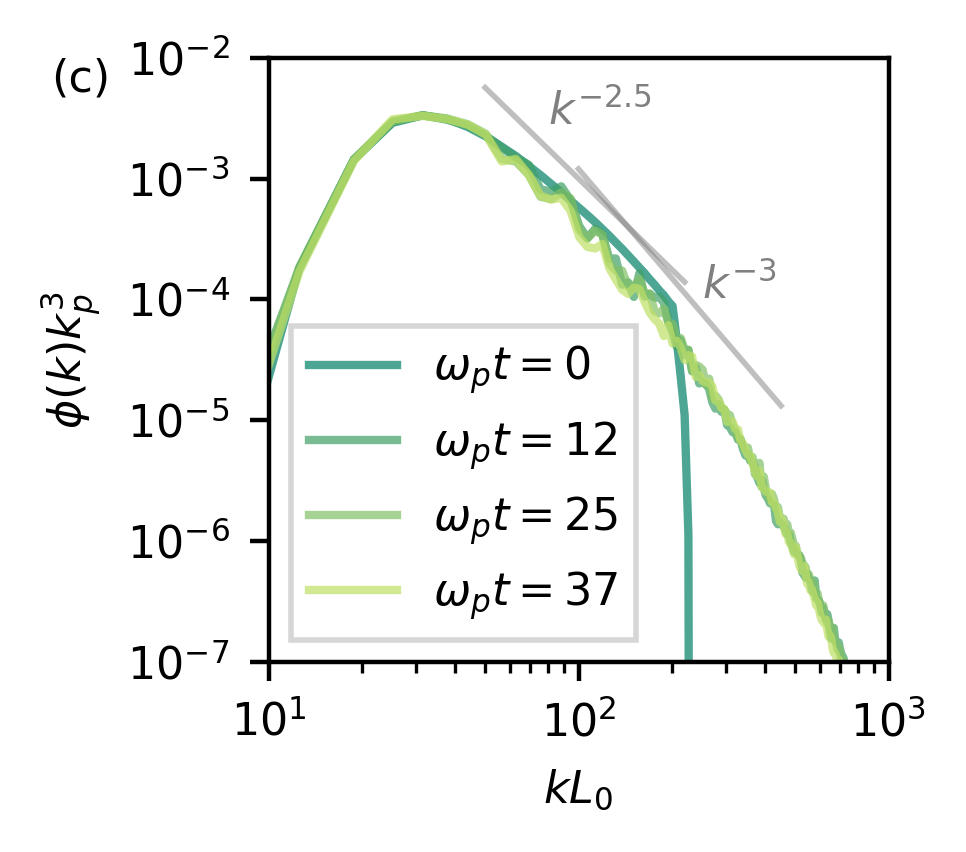

In [19]:
""" FIGURE: 1D spectrum with time, non-dimensional """

fig = plt.figure(figsize = [2,2])
N = 512; L = 200; kp = 2*np.pi/(L/5); omegap = (9.8*kp)**0.5
print('kp=%g, omegap=%g' %(kp,omegap))
# filepath = '/projects/DEIKE/jiarongw/multilayer/field_new_500m_P0.05_RE40000_9_15_rand2_Htheta0.503/'
filepath='/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.03_RE40000_9_15_rand2_Htheta0.503/'

for i in range(0, 40, 10):
    t = i
    filename = filepath + 'surface/eta_matrix_%g' %t
    eta = np.fromfile(filename, dtype=np.float32)
    eta = eta.reshape(N+1,N+1); eta = eta[1:,1:]
    wavenumber = 2*np.pi*np.fft.fftfreq(n=N,d=L/N)
    k = wavenumber[0:int(N/2)]  
    F = spectrum_integration(eta, L=L, N=N, CHECK=True)
    plt.plot(k*L, F*kp**3, color=plt.cm.get_cmap('summer')(i/40), label = r'$\omega_p t=%.0f$' %(omegap*t), alpha = 0.7)

    
ax = fig.gca()
ax.axvline(2*np.pi/(L/5),ls='--',color='C7',lw=1)
ax.plot(np.arange(50,220,0.05), np.arange(50,220,0.05)**(-2.5)*100, lw=1, c='gray', alpha=0.5)
ax.text(80, 0.0028, '$k^{-2.5}$', c='gray')
ax.text(250, 0.0001, '$k^{-3}$', c='gray')
ax.plot(np.arange(100,450,0.05), np.arange(100,450,0.05)**(-3.)*1200, lw=1, c='gray', alpha=0.5)
plt.xlabel('$kL_0$')
plt.ylabel('$\phi(k)k_p^3$')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend(loc='lower left', fancybox=False)

plt.xscale('log'); plt.yscale('log')
# Limit of resolution
N = 9; k_m = 2*np.pi/(L/2**N*4)
# ax.set_xlim([10,k_m*L])
ax.set_xlim([10,1000])
ax.set_ylim([10**(-7.),10**(-2)])
ax.set_yticks([10**(-7), 10**(-6), 10**(-5), 10**(-4), 10**(-3), 10**(-2)])
ax.text(-0.35, 1.0, '(c)', transform=ax.transAxes, fontsize='medium', verticalalignment='top')
# 
# fig.savefig('figures/spectrum_nondim.pdf', bbox_inches='tight', pad_inche=0.1)
fig.savefig('figures_vector/spectrum_nondim.eps', bbox_inches='tight', pad_inche=0)

In [6]:
""" Compute the large scale steepness """
def steepness_trunc (F,k):
    mu = np.zeros(len(k))
    dk = k[1]-k[0]
    for i,k_ in enumerate(k):
        mu[i] = np.sum(k[:i]**2*F[:i]*dk)
    return mu

0.1715495
0.17154948919862031
0.17082408639118893
0.1536455
0.15364549854759396
0.15284139717731382
0.14559066
0.14559064024256427
0.1446745105979866
0.14159952
0.14159955265981092
0.14065081834370416
0.13606963
0.1360696241660563
0.13563836160461845
0.13275121
0.13275121832077413
0.13223217340947577


(0.0, 0.5)

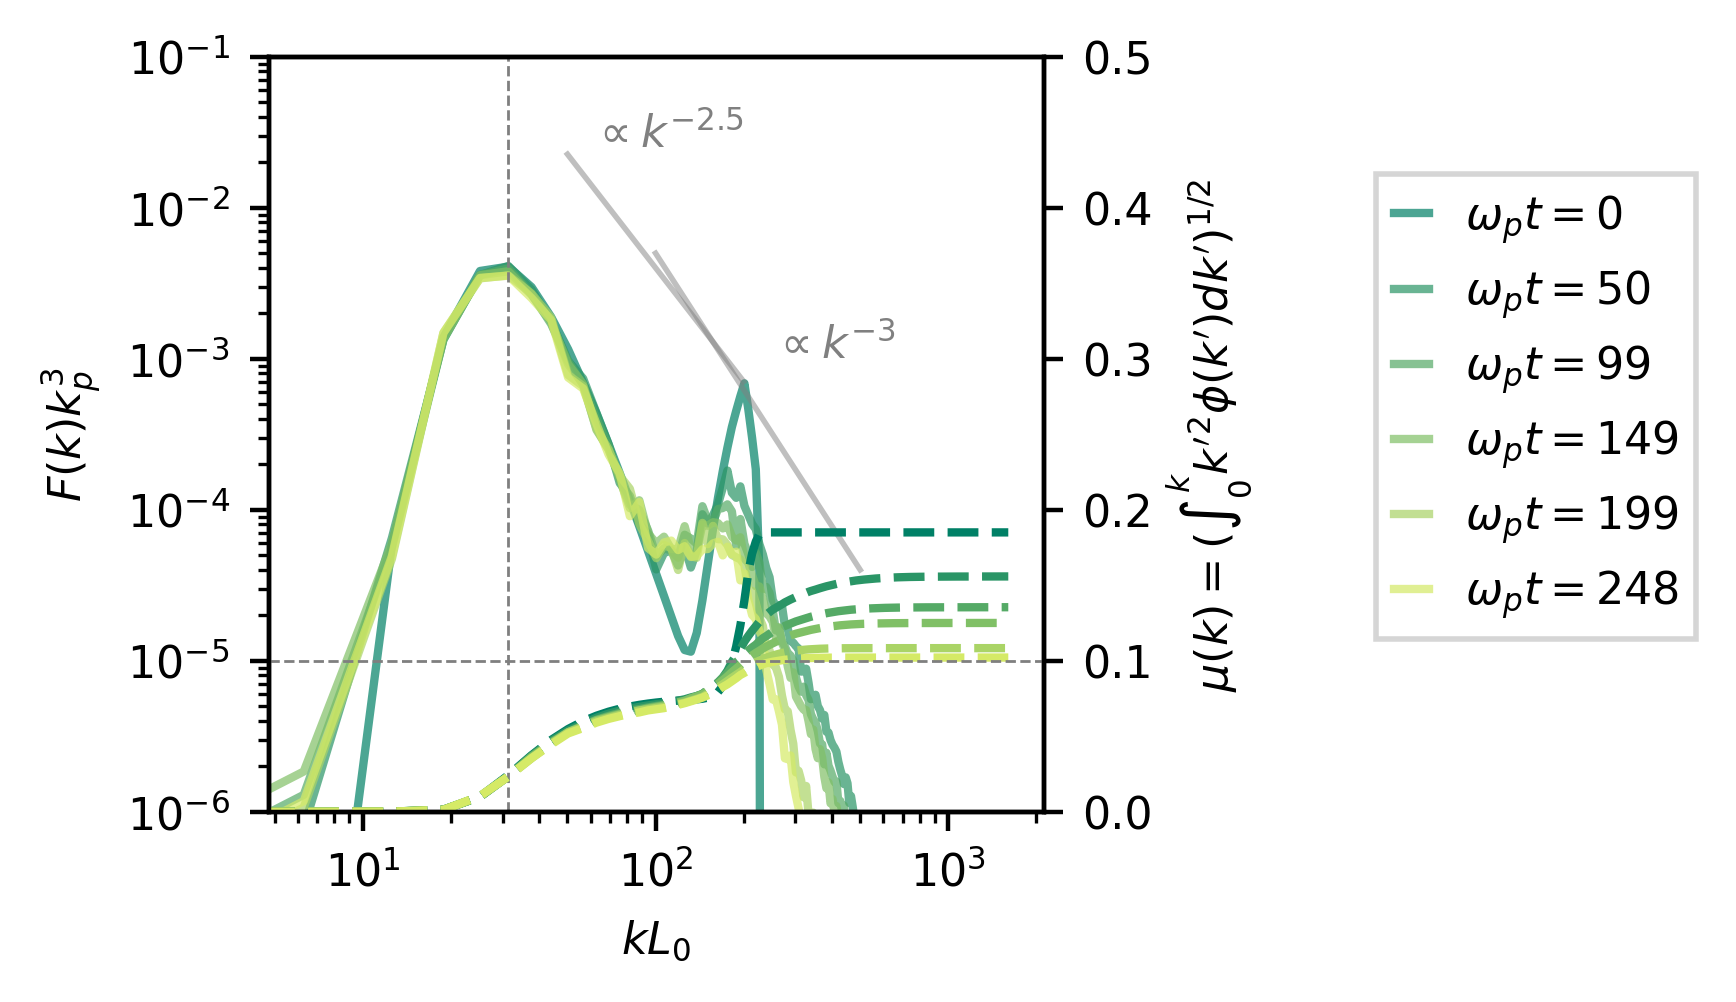

In [8]:
""" FIGURE: 1D spectrum with time, 500m """

fig = plt.figure(figsize = [2.5,2.5]); ax = plt.gca()
ax2 = ax.twinx()

N = 512; L = 200; kp = 2*np.pi/(L/5); omegap = (9.8*kp)**0.5
filepath = '/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.8_RE40000_9_15_rand2_Htheta0.503_alter1/'
filepath = '/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.2_RE40000_9_15_rand2_Htheta0.503_alter2/'
filepath = '/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.005_RE40000_9_15_rand2_Htheta0.503/'
filepath = '/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.05_RE40000_9_15_rand2_Htheta0.503_alter4/'
filepath = '/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.02_RE40000_9_15_rand2_Htheta0.503_alter3/'
filepath = '/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.005_RE40000_9_15_rand2_Htheta0.503_alter5/'
filepath = '/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.0002_RE40000_9_15_rand2_Htheta0.503_alter6/'
filepath = '/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.0005_RE40000_9_15_rand2_Htheta0.503_alter7/'
filepath = '/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.0002_RE40000_9_15_rand2_Htheta0.503_alter8/'

for i in range(0, 240, 40):
    t = i
    filename = filepath + 'surface/eta_matrix_%g' %t
    eta = np.fromfile(filename, dtype=np.float32)
    eta = eta.reshape(N+1,N+1); eta = eta[1:,1:]
    wavenumber = 2*np.pi*np.fft.fftfreq(n=N,d=L/N)
    k = wavenumber[0:int(N/2)]
    F = spectrum_integration(eta, L=L, N=N, CHECK=True)
    mu = steepness_trunc (F,k)
    ax.plot(k*L, F*kp**3, color=plt.cm.get_cmap('summer')(i/240), label = r'$\omega_p t=%.0f$' %(omegap*t), alpha = 0.7)
    ax2.plot(k*L, mu**0.5, '--', color=plt.cm.get_cmap('summer')(i/240))

ax.axvline(2*np.pi/(L/5)*L,ls='--',color='C7',lw=0.5)
ax.plot(np.arange(50,200,0.05), np.arange(50,200,0.05)**(-2.5)*400, lw=1, c='gray', alpha=0.5)
ax.text(60, 0.025, '$\propto k^{-2.5}$', c='gray')
ax.text(250, 0.001, '$\propto k^{-3}$', c='gray')
ax.plot(np.arange(100,500,0.05), np.arange(100,500,0.05)**(-3.)*5000, lw=1, c='gray', alpha=0.5)
ax.set_xlabel('$kL_0$')
ax.set_ylabel('$F(k)k_p^3$')
ax2.set_ylabel('$\mu(k) = (\int_0^{k} k\'^2\phi(k\')dk\')^{1/2}$', labelpad=2)
ax2.axhline(0.1,ls='--',color='C7',lw=0.5)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.legend(loc='lower left', fancybox=False, bbox_to_anchor=(1.4, 0.2), handlelength=0.8)

ax.set_xscale('log'); ax.set_yscale('log')
# Limit of resolution
N = 9; k_m = 2*np.pi/(L/2**N*4)
# ax.set_xlim([10,k_m*L])
# ax.set_xlim([10,1000])
ax.set_ylim([10**(-6.),10**(-1.)])
ax2.set_ylim([0,0.5])

# fig.savefig('figures/spectrum_nondim.pdf', bbox_inches='tight')

In [ ]:
""" FIGURE: 1D spectrum with time, 500m """

fig = plt.figure(figsize = [2.5,2.5])
N = 512; L = 200; kp = 2*np.pi/(L/5); omegap = (9.8*kp)**0.5
filepath='/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.8_RE40000_9_15_rand2_Htheta0.503_alter1/'
filepath = '/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.2_RE40000_9_15_rand2_Htheta0.503_alter2/'
filepath='/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.005_RE40000_9_15_rand2_Htheta0.503/'


for i in range(0, 60, 10):
    t = i
    filename = filepath + 'surface/eta_matrix_%g' %t
    eta = np.fromfile(filename, dtype=np.float32)
    eta = eta.reshape(N+1,N+1); eta = eta[1:,1:]
    wavenumber = 2*np.pi*np.fft.fftfreq(n=N,d=L/N)
    k = wavenumber[0:int(N/2)]
    F = spectrum_integration(eta, L=L, N=N, CHECK=True)
    mu = steepness_trunc (F,k)
    omega = (9.8*k)**0.5
    plt.plot(k*L, F*kp**3, color=plt.cm.get_cmap('summer')(i/60), label = r'$\omega_p t=%.0f$' %(omegap*t), alpha = 0.7)
    plt.plot(k*L, mu**0.5, '--', color=plt.cm.get_cmap('summer')(i/60))

ax = fig.gca()
ax.axvline(2*np.pi/(L/5),ls='--',color='C7',lw=1)
ax.plot(np.arange(50,200,0.05), np.arange(50,200,0.05)**(-2.5)*7000, lw=1, c='gray', alpha=0.5)
ax.text(60, 0.25, '$\propto k^{-2.5}$', c='gray')
ax.text(250, 0.01, '$\propto k^{-3}$', c='gray')
ax.plot(np.arange(100,300,0.05), np.arange(100,300,0.05)**(-3.)*90000, lw=1, c='gray', alpha=0.5)
plt.xlabel('$kL_0$')
plt.ylabel('$F(k)k_p^3$')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend(loc='lower left', fancybox=False)

plt.xscale('log'); plt.yscale('log')
# Limit of resolution
N = 9; k_m = 2*np.pi/(L/2**N*4)
# ax.set_xlim([10,k_m*L])
ax.set_xlim([10,1000])
ax.set_ylim([10**(-5.),10**(0.)])

# fig.savefig('figures/spectrum_nondim.pdf', bbox_inches='tight')

0.02130733
0.021307331374497723
0.021281750659591883
0.019763354
0.019763354180417962
0.019819734641566906
0.018489398
0.018489396741553844
0.01852939889904742
0.01754121
0.01754120995664006
0.01763609064547818
0.017102197
0.017102197742959572
0.01716618151180547
0.01596388
0.0159638794744118
0.015978937722918054


(1e-08, 1.0)

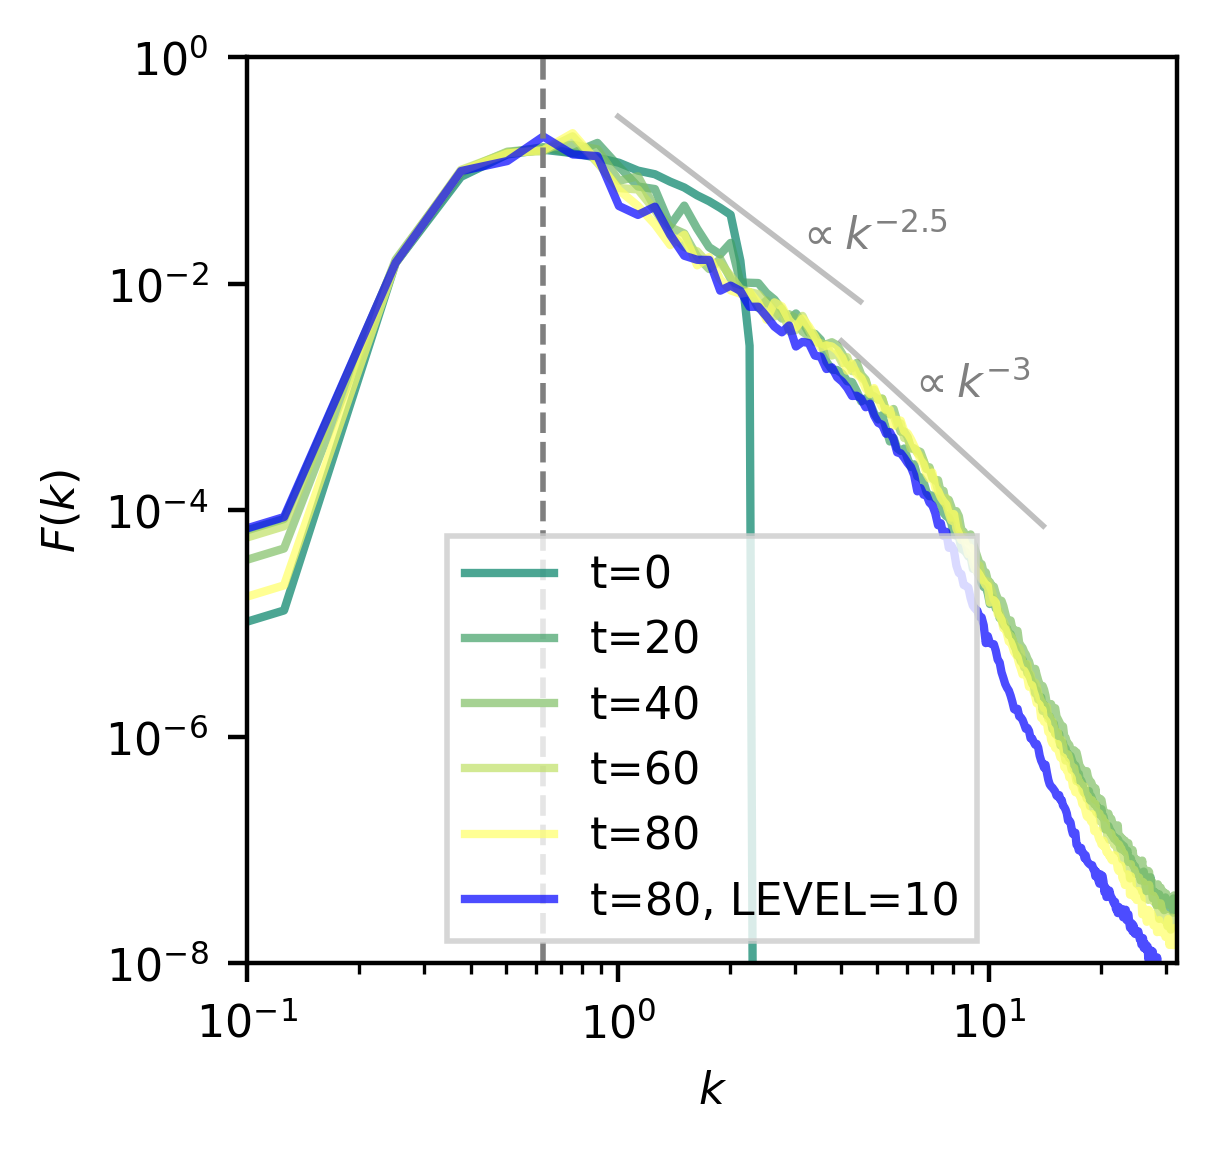

In [35]:
""" FIGURE: 1D spectrum with time, 50m """
fig = plt.figure(figsize = [3,3])
ax = fig.gca()
N = 512; L = 50
filepath = '/projects/DEIKE/jiarongw/multilayer/field_new_P0020_RE40000_9_30_rand4_noHtheta/'
# filepath = '/projects/DEIKE/jiarongw/multilayer/field_new_P0020_RE40000_9_30_rand0_Htheta051/'

for i in range(0, 100, 20):
    t = i
    filename = filepath + 'surface/eta_matrix_%g' %t
    eta = np.fromfile(filename, dtype=np.float32)
    eta = eta.reshape(N+1,N+1); eta = eta[1:,1:]
    wavenumber = 2*np.pi*np.fft.fftfreq(n=N,d=L/N)
    k = wavenumber[0:int(N/2)]
    F = spectrum_integration(eta, CHECK=True)
    plt.plot(k, F, color=plt.cm.get_cmap('summer')(i/80), label = 't=%g' %t, alpha = 0.7)
    

# """ Add the input spectrum, just the F_kmod """
# kp = 2*np.pi/50*5
# P = 0.02
# N_kmod = 64; # Uniform grid in kmod and ktheta
# N_mode = 16; # Uniform grid in kx and ky
# F_kmod = P*kmod**(-2.5)*np.exp(-0.75*(kp/kmod)**2)
# plt.plot(kmod, F_kmod/(kmod[1]-kmod[0]), c='gray', label='spectrum')
# # Add the input spectrum, after interpolation:
# N_power = 5; thetam = 0
# N_kmod = 64; N_theta = 64 # Uniform grid in kmod and ktheta
# N_mode = 16; # Uniform grid in kx and ky
# kmod = np.linspace(2*np.pi/L,1.5*N_mode*2*np.pi/L,N_kmod); theta = np.linspace(-0.5*np.pi, 0.5*np.pi, N_theta)
# kmod_tile, theta_tile = np.meshgrid(kmod,theta)
# F_kmod = P*kmod**(-2.5)*np.exp(-0.75*(kp/kmod)**2)
# D_theta = np.cos(theta-thetam)**N_power
# D_theta = D_theta/np.trapz(D_theta, theta) # Normalize so the sum equals one
# F_kmod_tile, D_theta_tile = np.meshgrid(F_kmod,D_theta) # Direct metrix multiplication in python
# F_kmodtheta_tile = F_kmod_tile*D_theta_tile
# dtheta = theta[1]-theta[0]
# # Project onto kx,ky
# delta = 0.5 # Step in kx and ky: controls how many x y modes we put in
# kx = np.arange(1,N_mode+1,delta)*2*np.pi/L # based on the grid, interval can't go smaller then pi/L
# ky = np.arange(-N_mode/2,N_mode/2+1,delta)*2*np.pi/L
# kx_tile, ky_tile = np.meshgrid(kx,ky)
# kxp_tile, kyp_tile = pol2cart(kmod_tile, theta_tile)
# """ Different interpolaion methods """
# # F_kxky_tile = griddata((kxp_tile.ravel(),kyp_tile.ravel()), F_kmodtheta_tile.ravel(), (kx_tile, ky_tile), 
# #                         method='nearest')
# # F_center_polar_tile = griddata((kx_tile.ravel(),ky_tile.ravel()), F_kxky_tile.ravel(), (kxp_tile, kyp_tile), method='nearest')
# # F_center_polar_integrated = np.sum(F_center_polar_tile*kmod_tile, axis=0)*dtheta # Azimuthal integration
# # plt.plot(kmod, F_center_polar_integrated/(kmod[1]-kmod[0]), ':', c='gray', label='nearest')
# F_kxky_tile = griddata((kxp_tile.ravel(),kyp_tile.ravel()), F_kmodtheta_tile.ravel(), (kx_tile, ky_tile), 
#                         method='linear', fill_value=0)
# F_center_polar_tile = griddata((kx_tile.ravel(),ky_tile.ravel()), F_kxky_tile.ravel(), (kxp_tile, kyp_tile), method='linear', fill_value=0)
# F_center_polar_integrated = np.sum(F_center_polar_tile*kmod_tile, axis=0)*dtheta # Azimuthal integration
# plt.plot(kmod, F_center_polar_integrated/(kmod[1]-kmod[0]), ':', c='gray', label='linear')

# """ LEVEL 10 case """
filepath = '/projects/DEIKE/jiarongw/multilayer/field_new_P0020_adaptive_RE40000_9_30_rand8_noHtheta/'
t = 80
filename = filepath + 'surface/eta_matrix_%g' %t
eta = np.fromfile(filename, dtype=np.float32)
eta = eta.reshape(N+1,N+1); eta = eta[1:,1:]
wavenumber = 2*np.pi*np.fft.fftfreq(n=N,d=L/N)
k = wavenumber[0:int(N/2)]
F = spectrum_integration(eta, CHECK=True)
plt.plot(k, F, color='blue', label = 't=%g, LEVEL=10' %t, alpha = 0.7)
    
ax.axvline(2*np.pi/(L/5),ls='--',color='C7',lw=1) 
ax.plot(np.arange(1,5,0.5), np.arange(1,5,0.5)**(-2.5)*0.3, lw=1, c='gray', alpha=0.5)
ax.text(3, 0.02, '$\propto k^{-2.5}$', c='gray')
ax.text(6, 0.001, '$\propto k^{-3}$', c='gray')
ax.plot(np.arange(4,15), np.arange(4,15)**(-3.)*0.2, lw=1, c='gray', alpha=0.5)
plt.xlabel('$k$')
plt.ylabel('$F(k)$')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend(loc='lower center', fancybox=False)
plt.xscale('log'); plt.yscale('log')
# Limit of resolution
N = 10; k_m = 2*np.pi/(L/2**N*4)
ax.set_xlim([0.1,k_m])
ax.set_ylim([10**(-8.),10**(0.)])

0.18498484570426446
0.11973993997902746
0.08774942275895314
0.040466073384542674


(1e-08, 1.0)

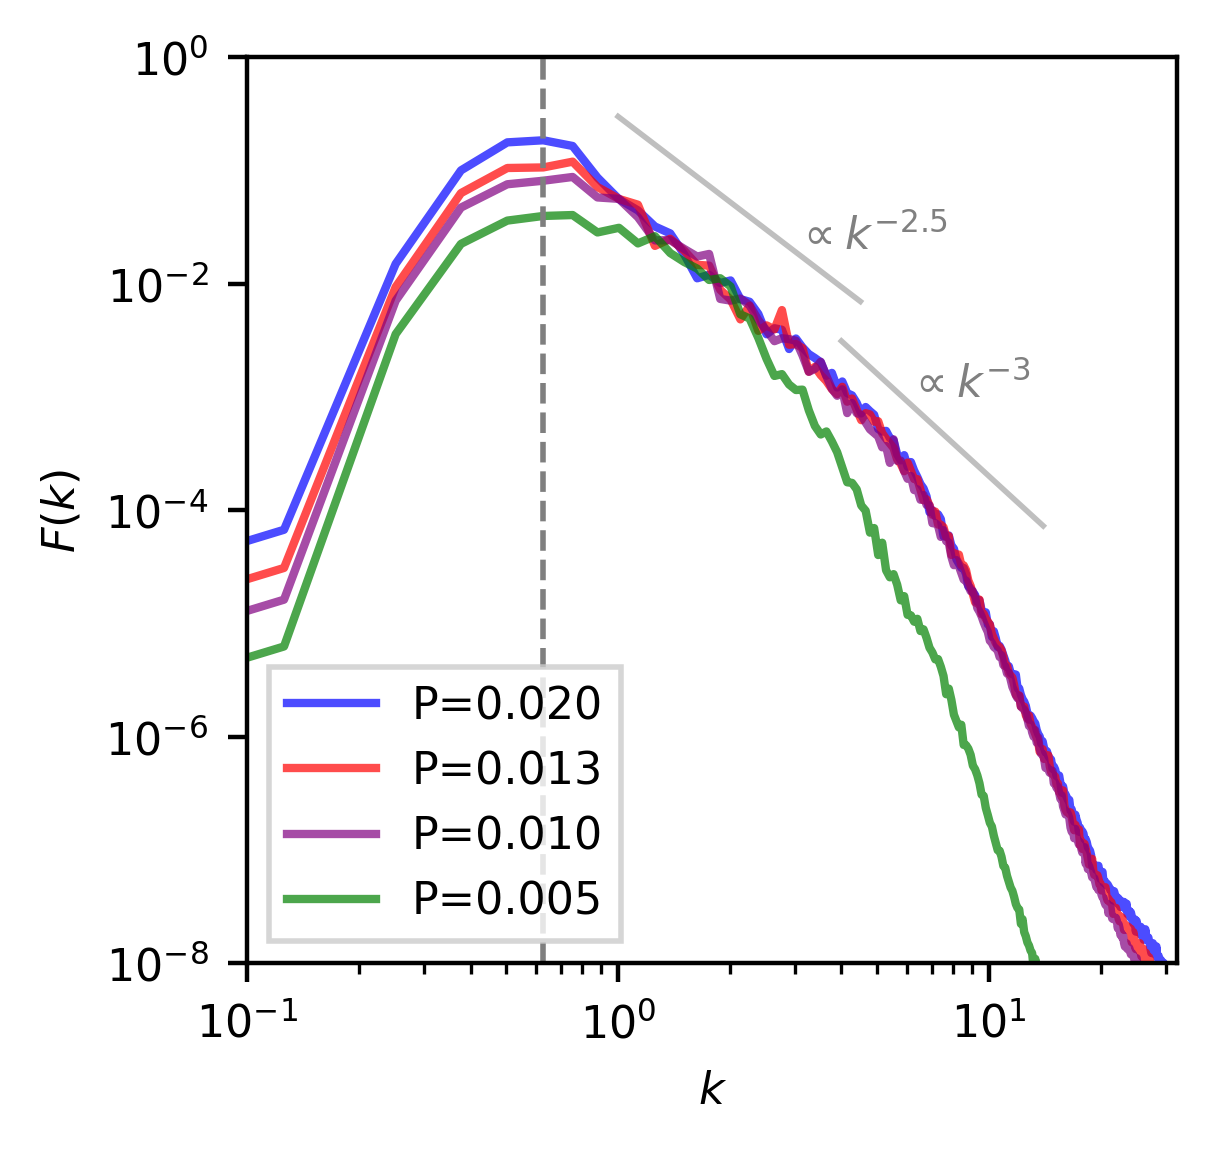

In [61]:
""" FIGURE: 1D spectrum with time, 50m """
fig = plt.figure(figsize = [3,3])
ax = fig.gca()
N = 512; L = 50

# filepath='/projects/DEIKE/jiarongw/multilayer/field_new_P0013_RE40000_9_15_rand2_Htheta0.51/'
# # filepath='/projects/DEIKE/jiarongw/multilayer/field_new_P0013_RE40000_9_15_rand2_noHtheta/'
# for i in range(0, 100, 20):
#     t = i
#     filename = filepath + 'surface/eta_matrix_%g' %t
#     eta = np.fromfile(filename, dtype=np.float32)
#     eta = eta.reshape(N+1,N+1); eta = eta[1:,1:]
#     wavenumber = 2*np.pi*np.fft.fftfreq(n=N,d=L/N)
#     k = wavenumber[0:int(N/2)]
#     F = spectrum_integration(eta, CHECK=False)
#     plt.plot(k, F, color=plt.cm.get_cmap('summer')(i/100))
#     print(F.max())

filepath='/projects/DEIKE/jiarongw/multilayer/field_new_P0020_RE40000_9_15_rand2_noHtheta/'
t = 80
filename = filepath + 'surface/eta_matrix_%g' %t
eta = np.fromfile(filename, dtype=np.float32)
eta = eta.reshape(N+1,N+1); eta = eta[1:,1:]
wavenumber = 2*np.pi*np.fft.fftfreq(n=N,d=L/N)
k = wavenumber[0:int(N/2)]
F = spectrum_integration(eta, CHECK=False)
plt.plot(k, F, color='blue', label = 'P=0.020', alpha = 0.7)
print(F.max())

filepath='/projects/DEIKE/jiarongw/multilayer/field_new_P0013_RE40000_9_15_rand2_noHtheta/'
t = 80
filename = filepath + 'surface/eta_matrix_%g' %t
eta = np.fromfile(filename, dtype=np.float32)
eta = eta.reshape(N+1,N+1); eta = eta[1:,1:]
wavenumber = 2*np.pi*np.fft.fftfreq(n=N,d=L/N)
k = wavenumber[0:int(N/2)]
F = spectrum_integration(eta, CHECK=False)
plt.plot(k, F, color='red', label = 'P=0.013', alpha = 0.7)
print(F.max())

filepath='/projects/DEIKE/jiarongw/multilayer/field_new_P0010_RE40000_9_15_rand2_noHtheta/'
t = 80
filename = filepath + 'surface/eta_matrix_%g' %t
eta = np.fromfile(filename, dtype=np.float32)
eta = eta.reshape(N+1,N+1); eta = eta[1:,1:]
wavenumber = 2*np.pi*np.fft.fftfreq(n=N,d=L/N)
k = wavenumber[0:int(N/2)]
F = spectrum_integration(eta, CHECK=False)
plt.plot(k, F, color='purple', label = 'P=0.010', alpha = 0.7)
print(F.max())

filepath='/projects/DEIKE/jiarongw/multilayer/field_new_P0005_RE40000_9_15_rand2_noHtheta/'
t = 80
filename = filepath + 'surface/eta_matrix_%g' %t
eta = np.fromfile(filename, dtype=np.float32)
eta = eta.reshape(N+1,N+1); eta = eta[1:,1:]
wavenumber = 2*np.pi*np.fft.fftfreq(n=N,d=L/N)
k = wavenumber[0:int(N/2)]
F = spectrum_integration(eta, CHECK=False)
plt.plot(k, F, color='green', label = 'P=0.005', alpha = 0.7)
print(F.max())
    
ax.axvline(2*np.pi/(L/5),ls='--',color='C7',lw=1) 
ax.plot(np.arange(1,5,0.5), np.arange(1,5,0.5)**(-2.5)*0.3, lw=1, c='gray', alpha=0.5)
ax.text(3, 0.02, '$\propto k^{-2.5}$', c='gray')
ax.text(6, 0.001, '$\propto k^{-3}$', c='gray')
ax.plot(np.arange(4,15), np.arange(4,15)**(-3.)*0.2, lw=1, c='gray', alpha=0.5)
plt.xlabel('$k$')
plt.ylabel('$F(k)$')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend(loc='lower left', fancybox=False)
plt.xscale('log'); plt.yscale('log')
# Limit of resolution
N = 10; k_m = 2*np.pi/(L/2**N*4)
ax.set_xlim([0.1,k_m])
ax.set_ylim([10**(-8.),10**(0.)])

In [112]:
from scipy.interpolate import LinearNDInterpolator, griddata
def spectrum_integration(eta, CHECK=False, N=512, L=50):
    """ This function performs azimuthal integration of the 2D spectrum (Notice it's 2D instead of 3D with the frequency as well).
        When in doubt, enable CHECK so that the integration is printed out at each step to make sure that 
        units are consistent and we always recover the variance of the data. """  
    if CHECK: print (np.var(eta))
    spectrum = np.fft.fft2(eta) / (N*N)**0.5 # FFT normalization 
    F = np.absolute(spectrum)**2 / N**2 # Per area normalization
    if CHECK: print (np.sum(F))
    wavenumber = 2*np.pi*np.fft.fftfreq(n=N,d=L/N)
    kx = np.fft.fftshift(wavenumber); ky = kx
    kx_tile, ky_tile = np.meshgrid(kx,ky)
    theta = np.arange(-N/2,N/2)/(N)*2*np.pi
#     k = np.linspace(2*np.pi/L,1.5*32*2*np.pi/L,32)    
    k = wavenumber[0:int(N/2)]
    dkx = kx[1] - kx[0]; dky = ky[1] - ky[0]
    dk = k[1]-k[0]; dtheta = theta[1]-theta[0]
    F_center = np.fft.fftshift(F)/dkx/dky # Further normalization by independent variables
    k_tile, theta_tile = np.meshgrid(k,theta)
    kxp_tile, kyp_tile = pol2cart(k_tile, theta_tile)
    F_center_polar = griddata((kx_tile.ravel(),ky_tile.ravel()), F_center.ravel(), (kxp_tile, kyp_tile), method='linear', fill_value=0)
    F_center_polar_integrated = np.sum(F_center_polar*k_tile, axis=0)*dtheta # Azimuthal integration
    if CHECK: print (np.sum(F_center_polar_integrated)*dk)
    return F_center_polar_integrated

0.009575003
0.009575002851113536
0.009580703150151417
0.009191874
0.009191875267978272
0.009194838551571412
0.008863681
0.008863680892048248
0.008825824193886299
Integral 1 = 0.00996441
Integral 2 = 0.00958881
Integral 3 = 0.00955607
Integral 4 = 0.00955607
0.0


(1e-10, 10)

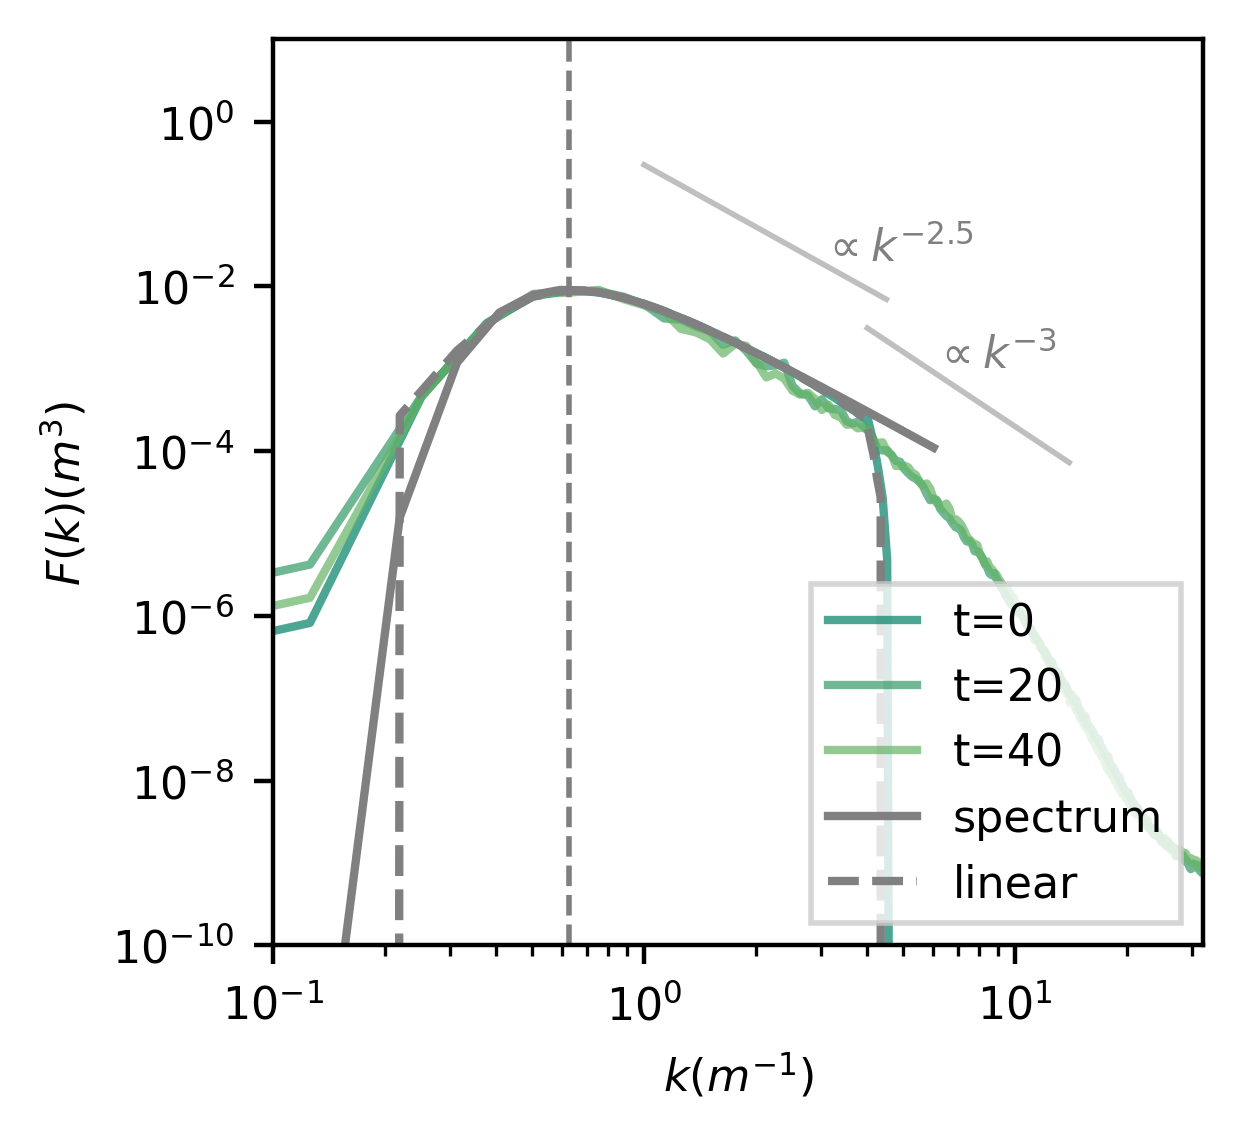

In [117]:
""" FIGURE: 1D spectrum with time, 50m """
fig = plt.figure(figsize = [3,3])
ax = fig.gca()
N = 512; L = 50

filepath = '/projects/DEIKE/jiarongw/multilayer/field_new_50m_P0.01_RE40000_9_15_rand2_Htheta0.503/'

for i in range(0, 60, 20):
    t = i
    filename = filepath + 'surface/eta_matrix_%g' %t
    eta = np.fromfile(filename, dtype=np.float32)
    eta = eta.reshape(N+1,N+1); eta = eta[1:,1:]
    wavenumber = 2*np.pi*np.fft.fftfreq(n=N,d=L/N)
    k = wavenumber[0:int(N/2)]
#     k = np.linspace(2*np.pi/L,1.5*32*2*np.pi/L,128)  
    F = spectrum_integration(eta, CHECK=True, N=512, L=50)
    plt.plot(k, F, color=plt.cm.get_cmap('summer')(i/100), label = 't=%g' %t, alpha = 0.7)
#     kpHs = np.var(eta)**0.5*kp*4
#     print(kpHs)

""" Add the input spectrum, just the F_kmod """
kp = 2*np.pi/L*5
P = 0.01
N_power = 5; thetam = 0
N_kmod = 64; N_theta = 64 # Uniform grid in kmod and ktheta
N_mode = 32; # Uniform grid in kx and ky
kmod = np.linspace(2*np.pi/L,1.5*N_mode*2*np.pi/L,N_kmod) # 1.5 so that it's above the 1.44 ratio
dk = kmod[1] - kmod[0]
F_kmod = P*kmod**(-2.5)*np.exp(-1.25*(kp/kmod)**2)
plt.plot(kmod, F_kmod, c='gray', label='spectrum')
print('Integral 1 = %g' %(np.sum(F_kmod)*dk))

# Add the input spectrum, after interpolation:
kmod = np.linspace(2*np.pi/L,1.5*N_mode*2*np.pi/L,N_kmod); theta = np.linspace(-0.5*np.pi, 0.5*np.pi, N_theta)
kmod_tile, theta_tile = np.meshgrid(kmod,theta)
F_kmod = P*kmod**(-2.5)*np.exp(-1.25*(kp/kmod)**2)
D_theta = np.cos(theta-thetam)**N_power
dtheta = theta[1]-theta[0]
dk = kmod[1]-kmod[0]
# print('Theta integral = %g' %np.trapz(D_theta, theta))
# print('Theta integral = %g' %np.sum(D_theta*dtheta))
D_theta = D_theta/np.trapz(D_theta, theta) # Normalize so the sum equals one

F_kmod_tile, D_theta_tile = np.meshgrid(F_kmod,D_theta) # Direct metrix multiplication in python
F_kmodtheta_tile = F_kmod_tile*D_theta_tile/kmod_tile
# Project onto kx,ky
delta = 1 # Step in kx and ky: controls how many x y modes we put in
kx = np.arange(1,N_mode+1,delta)*2*np.pi/L # based on the grid, interval can't go smaller then pi/L
ky = np.arange(-N_mode/2,N_mode/2+1,delta)*2*np.pi/L
dkx = kx[1] - kx[0]; dky = ky[1] - ky[0];
kx_tile, ky_tile = np.meshgrid(kx,ky)
kxp_tile, kyp_tile = pol2cart(kmod_tile, theta_tile)
""" Different interpolaion methods """
# F_kxky_tile = griddata((kxp_tile.ravel(),kyp_tile.ravel()), F_kmodtheta_tile.ravel(), (kx_tile, ky_tile), 
#                         method='nearest')
# F_center_polar_tile = griddata((kx_tile.ravel(),ky_tile.ravel()), F_kxky_tile.ravel(), (kxp_tile, kyp_tile), method='nearest')
# F_center_polar_integrated = np.sum(F_center_polar_tile*kmod_tile, axis=0)*dtheta # Azimuthal integration
# plt.plot(kmod, F_center_polar_integrated/(kmod[1]-kmod[0]), ':', c='gray', label='nearest')
F_kxky_tile = griddata((kxp_tile.ravel(),kyp_tile.ravel()), F_kmodtheta_tile.ravel(), (kx_tile, ky_tile), 
                        method='linear', fill_value=0) # Interpolate from kxp,kyp (uniform in k) to kx,ky (uniform in kx,ky)
print('Integral 2 = %g' %(np.sum(F_kxky_tile)*dkx*dky))

F_center_polar_tile = griddata((kx_tile.ravel(),ky_tile.ravel()), F_kxky_tile.ravel(), (kxp_tile, kyp_tile), 
                                method='linear', fill_value=0) # Interpolate back onto kxp,kyp
print('Integral 3 = %g' %(np.sum(F_center_polar_tile*kmod_tile)*dk*dtheta))
F_center_polar_integrated = np.sum(F_center_polar_tile*kmod_tile, axis=0)*dtheta # Azimuthal integration 


""" We do not need this dtheta!!! """ 
plt.plot(kmod, F_center_polar_integrated, '--', c='gray', label='linear')
print('Integral 4 = %g' %(np.sum(F_center_polar_integrated)*dk))
print(F_center_polar_integrated[0])


ax.axvline(2*np.pi/(L/5),ls='--',color='C7',lw=1) 
ax.plot(np.arange(1,5,0.5), np.arange(1,5,0.5)**(-2.5)*0.3, lw=1, c='gray', alpha=0.5)
ax.text(3, 0.02, '$\propto k^{-2.5}$', c='gray')
ax.text(6, 0.001, '$\propto k^{-3}$', c='gray')
ax.plot(np.arange(4,15), np.arange(4,15)**(-3.)*0.2, lw=1, c='gray', alpha=0.5)
plt.xlabel('$k(m^{-1})$')
plt.ylabel('$F(k)(m^3)$')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend(loc='lower right', fancybox=False)
plt.xscale('log'); plt.yscale('log')
# Limit of resolution
N = 10; k_m = 2*np.pi/(L/2**N*4)
ax.set_xlim([0.1,k_m])
ax.set_ylim([10**(-10.),10**(1)])

In [56]:
""" wave numer to frequency g = 9.8 """
k = 0.1
omega = (g*k)**0.5
print(omega)
print(omega/2/np.pi)

0.9899494936611666
0.15755535532749357


In [6]:
""" Friction velocity and Stokes drift """
g = 16
k = 2*np.pi/4
omega = (g*k)**0.5
ak = 0.2
# Us = omega*k*(ak/k)**2
c = omega/k
Us = (ak)**2*c
print(Us)
print((0.25/Us)**2)

0.12766152972845848
3.8349519697141017


In [ ]:
""" For checking purpose: here are the input spectrum """

from scipy.interpolate import LinearNDInterpolator, griddata
def spectrum_gen(kp=2*np.pi/100, P=0.45, L=500):
    # Spectrum in polar coordinate
    N_power = 5; thetam = 0
    N_kmod = 64; N_theta = 64 # Uniform grid in kmod and ktheta
    N_mode = 16; # Uniform grid in kx and ky
    kmod = np.linspace(2*np.pi/L,1.5*N_mode*2*np.pi/L,N_kmod); theta = np.linspace(-0.5*np.pi, 0.5*np.pi, N_theta)
    kmod_tile, theta_tile = np.meshgrid(kmod,theta)
    F_kmod = P*kmod**(-2.5)*np.exp(-0.75*(kp/kmod)**2)
    D_theta = np.cos(theta-thetam)**N_power
    D_theta = D_theta/np.trapz(D_theta, theta) # Normalize so the sum equals one
    F_kmod_tile, D_theta_tile = np.meshgrid(F_kmod,D_theta) # Direct metrix multiplication in python
    F_kmodtheta_tile = F_kmod_tile*D_theta_tile
    # Project onto kx,ky
    delta = 1 # Step in kx and ky: controls how many x y modes we put in
    kx = np.arange(1,N_mode+1,delta)*2*np.pi/L # based on the grid, interval can't go smaller then pi/L
    ky = np.arange(-N_mode/2,N_mode/2+1,delta)*2*np.pi/L
    dkx = kx[1]-kx[0]; dky = ky[1]-ky[0]
    kx_tile, ky_tile = np.meshgrid(kx,ky)
    kxp_tile, kyp_tile = pol2cart(kmod_tile, theta_tile)
    F_kxky_tile = griddata((kxp_tile.ravel(),kyp_tile.ravel()), F_kmodtheta_tile.ravel(), (kx_tile, ky_tile), 
                           method='nearest')
    return kmod, F_kmod, kx_tile, ky_tile, F_kxky_tile

# Spectrum for L0 = 50
kp = 2*np.pi/10 # peak at 10m
P = 0.02
kmod, F_kmod, kx_tile, ky_tile, F_kxky_tile = spectrum_gen(kp, P, L=50)
# Some visualization:
# plt.plot(kmod, F_kmod, '.')
# plt.ylabel('F(k)'); plt.xlabel('k')
plt.imshow(F_kxky_tile, extent=[kx_tile[0,0],kx_tile[-1,-1],ky_tile[0,0],ky_tile[-1,-1]])
plt.ylabel('ky'); plt.xlabel('kx')

In [39]:
N = 9
lambda_m = 50/2**N*4
k_m = 2*np.pi/(50/2**N*4)
print(k_m)

16.084954386379742

### Wind wave case

In [21]:
sys.path.append('/projects/DEIKE/jiarongw/jiarongw-postprocessing/jupyter_notebook/project_specific/turbulence/')
from defs import Case, Interface2D

kl_c = 0.44
2*pi*k/k_c = 0.44
k_c 

kp=4, omegap=2
Pruning points above 1.1!
0.0012718343869310743
1.0013049223986688
0.0013120331607494801
Pruning points above 1.1!
0.0018368588170371632
1.0018040319303763
0.0018952229971445215
Pruning points above 1.1!
0.002301453063393837
1.0022474626346232
0.0023750026387036704


/tmp/ipykernel_160589/710263307.py:8: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interface = Interface2D(L0 = L, N = N, path = filepath,


Pruning points above 1.1!
0.0024198060539069913
1.0023554368276433
0.0024968946552089933
Pruning points above 1.1!
0.0025447493253614884
1.0024582245476013
0.0026265802620559857


(1e-07, 10)

findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


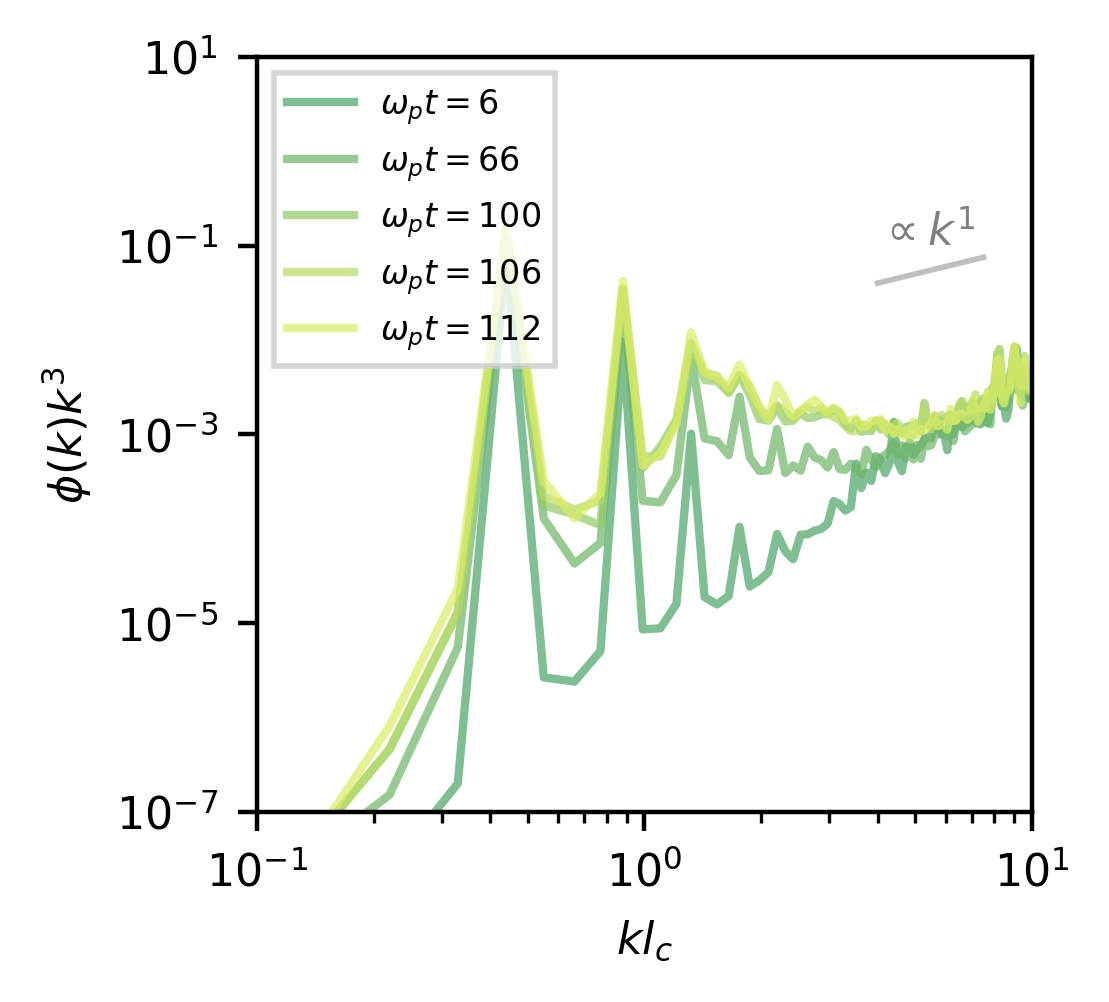

In [23]:
fig = plt.figure(figsize = [2.5,2.5]); ax =plt.gca()
N = 512; L = 2*np.pi; kp = 4; omegap = (1*kp)**0.5; lc = 0.44/kp
print('kp=%g, omegap=%g' %(kp,omegap))
# filepath = '/projects/DEIKE/jiarongw/multilayer/field_new_500m_P0.05_RE40000_9_15_rand2_Htheta0.503/'
filepath='/projects/DEIKE/jiarongw/turbulence/curved_fixREtau_boundary_REtau720_BO200_g1_ak0.2_MU16_LEVEL10_emax0.3/restart_highfreq/'

for i,t in enumerate([60,90,107,110,113]):
    interface = Interface2D(L0 = L, N = N, path = filepath, 
                            pre='eta_highfreq/eta_loc_t', t = t, PRUNING=True, pruningz=1+0.4/4)
    eta = interface.eta
    wavenumber = 2*np.pi*np.fft.fftfreq(n=N,d=L/N)
    k = wavenumber[0:int(N/2)]  
    F = spectrum_integration(eta, L=L, N=N, CHECK=True)
#     plt.plot(k*lc, F*kp**3, color=plt.cm.get_cmap('summer')((i+2)/7), label = r'$\omega_p t=%.0f$' %(omegap*(t-57)), alpha = 0.7)
    plt.plot(k*lc, F*k**3, '-', color=plt.cm.get_cmap('summer')((i+2)/7), label = r'$\omega_p t=%.0f$' %(omegap*(t-57)), alpha = 0.7)
    
plt.xlabel('$kl_c$')
plt.ylabel('$\phi(k)k^3$')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fancybox=False, fontsize=6)
plt.legend(loc='upper left', fancybox=False, fontsize=6)

ax.plot(np.arange(4,8,0.5), np.arange(4,8,0.5)**(1)*10**(-2), lw=1, c='gray', alpha=0.5)
ax.text(4, 0.1, '$\propto k^{1}$', c='gray')

plt.xscale('log'); plt.yscale('log')
# ax.set_xlim([10,k_m*L])
ax.set_xlim([0.1,10])
ax.set_ylim([10**(-7.),10**1])

In [24]:
'''3D fft: read in data and store as 3D array, take the 500m box as an example '''
# filepath = '/projects/DEIKE/jiarongw/multilayer/field_new_500m_P0.05_RE40000_9_15_rand2_Htheta0.503/'
filepath='/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.03_RE40000_9_15_rand2_Htheta0.503/'
# filepath='/projects/DEIKE/jiarongw/multilayer/field_new_50m_P0.02_RE40000_9_15_rand2_Htheta0.503/'
# filepath='/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.8_RE40000_9_15_rand2_Htheta0.503_alter1/'
# filepath='/projects/DEIKE/jiarongw/multilayer/field_new_200m_P0.2_RE40000_9_15_rand2_Htheta0.503_alter2/'

N = 512
time = np.arange(0,256)*0.05 + 100.05
Nt = 256 # number of frames
eta_series = np.load('eta_256_512.npy')

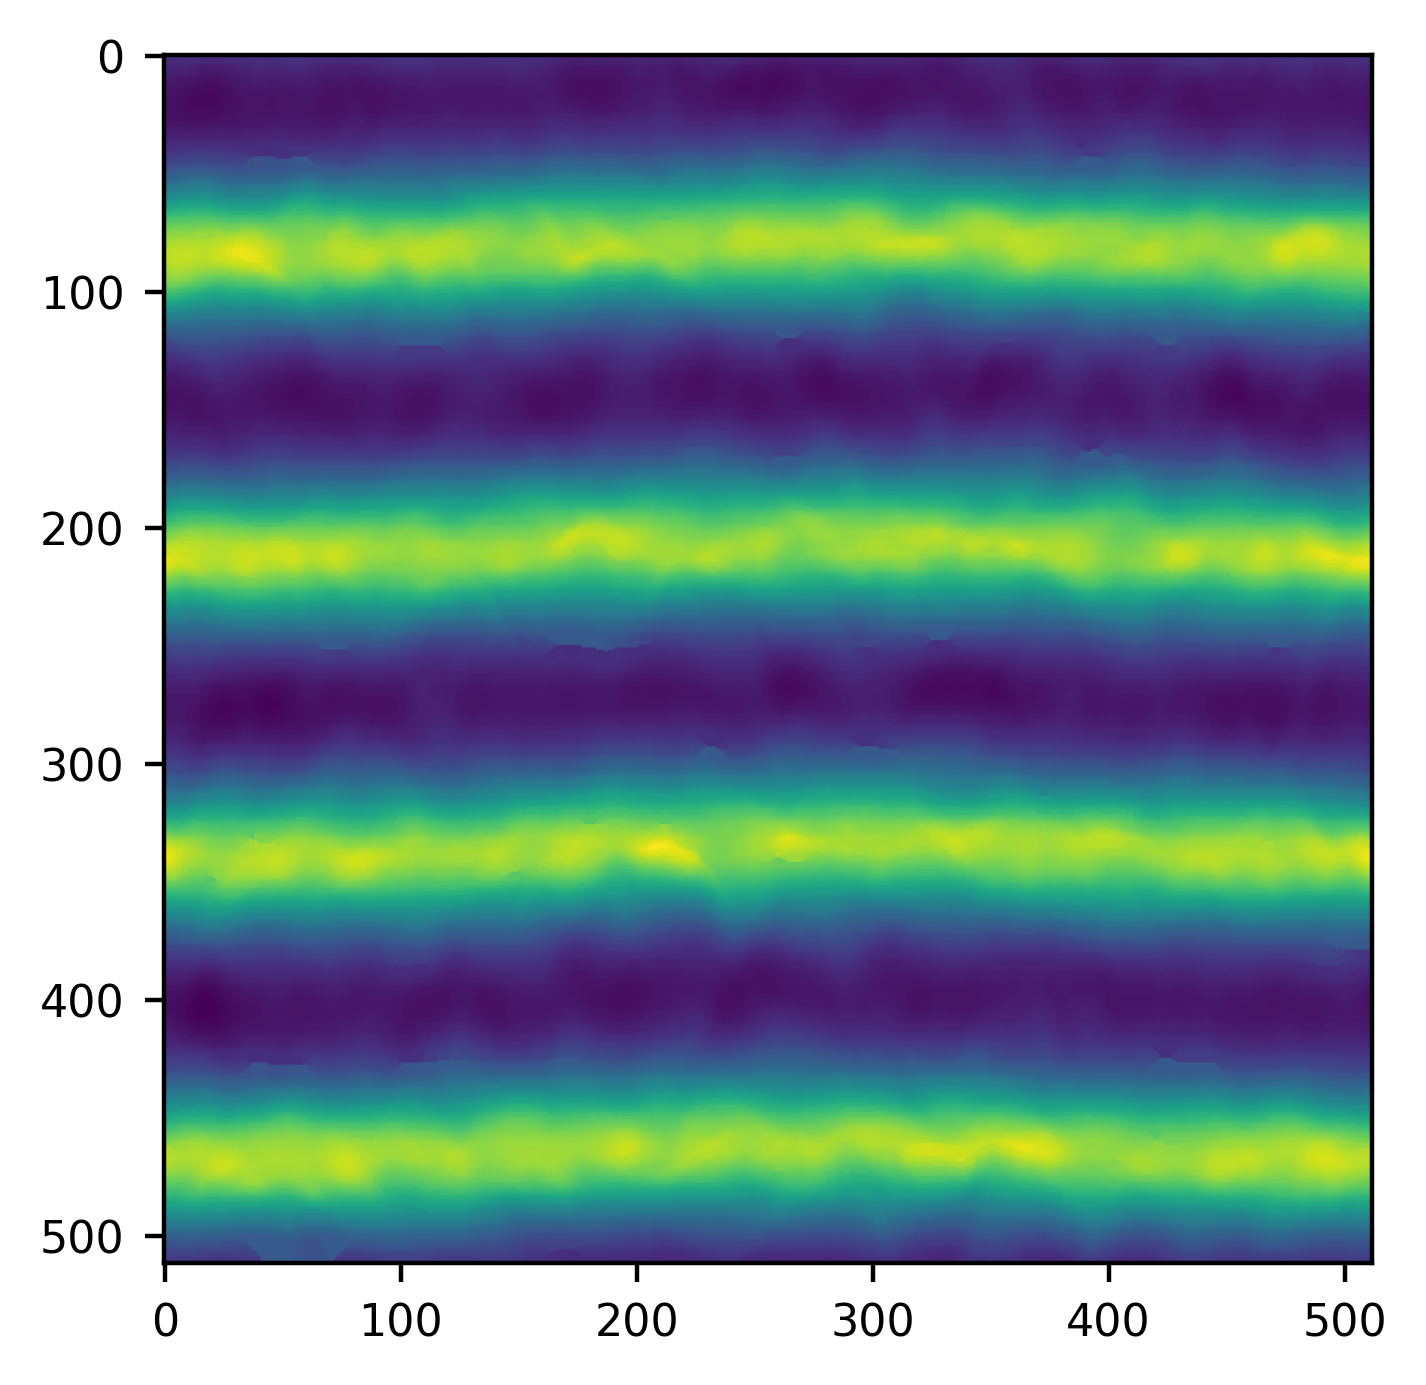

In [38]:
plt.imshow(eta_series[0])

In [25]:
data = eta_series

dt = 0.05   # sampling frequency, (Hz)
# L0 = 500.; N = 512 # Domain size and grid number in each direction
L0 = 2*np.pi; N = 512 # Domain size and grid number in each direction
# L0 = 50.; N = 512 # Domain size and grid number in each direction

dx = L0/N     # spatial sampling step along X in (m)
dy = L0/N      # spatial sampling step along Y in (m)
t_max = dt * data.shape[0]  # s
x_max = dx * data.shape[1]  # m
y_max = dy * data.shape[2]  # m
x = np.linspace(0, x_max, data.shape[1])   # m
y = np.linspace(0, y_max, data.shape[2])   # m
xx,yy = np.meshgrid(x, y, indexing='ij')
omega = np.linspace(-np.pi / dt, np.pi / dt, data.shape[0])                          # frequency (Hz)
kx = np.linspace(-np.pi / dx, np.pi / dx, data.shape[1])  # wavenumber along X axis (rad/mm)
ky = np.linspace(-np.pi / dy, np.pi / dy, data.shape[2])  # wavenumber along Y axis (rad/mm)
Ky, Kx = np.meshgrid(ky, kx, indexing='ij')
Omega, K = np.meshgrid(omega, kx, indexing='ij')

In [26]:
# Fourrier transform along Y, X and T axes to obtain ky, kx, f
dkx = kx[1]-kx[0]; dky = ky[1]-ky[0]; domega = omega[1]-omega[0]
spectrum_3d = np.fft.fftn(data) / (N*N*Nt)**0.5          
# Apply frequency shift along spatial dimentions 
# that zero-frequency component appears at the center of the spectrum
spectrum_3d = np.fft.fftshift(spectrum_3d, axes=(0,1,2))
F_3D = (np.absolute(spectrum_3d))**2 / N**2 / Nt / (dkx*dky*domega)

/tmp/ipykernel_160589/2476879812.py:19: RuntimeWarning: divide by zero encountered in log
  psd = plt.pcolormesh(omega[a:-a]/omega_lc, radii*lc, np.log((F_komega[:,a:-a]+F_komega[:,-a:-1:a])/2/np.max(F_komega[:,a:-a])), vmax=-10, vmin=-20)


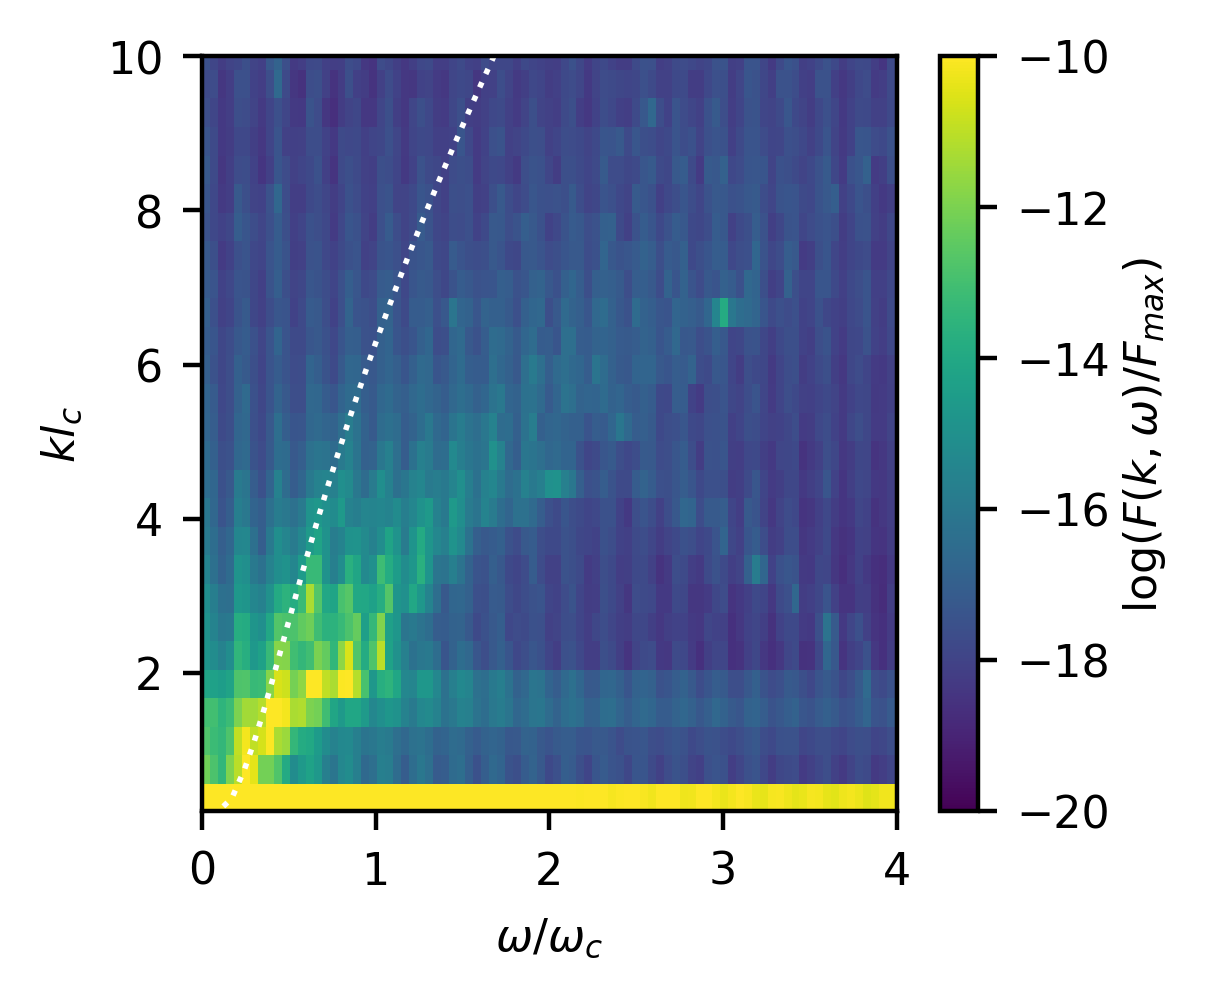

In [52]:
""" Dispersion relation """

fig = plt.figure(figsize=[2.8,2.5]); ax = plt.gca()
# F_3D has dimension omega*kx*ky
# F_komega = np.zeros((100, F_3D.shape[0])) # F_komega of dimension nr*omega
# lim = 20
# # """ The make_r_theta_vals function has theta as axis 0 """
# for i in range(0, F_3D.shape[0]):
#     radii, thetas, F_rtheta = make_r_theta_vals(xs=kx[lim:-lim],ys=ky[lim:-lim],F_xy=F_3D[i][lim:-lim,lim:-lim],ntheta=100,nr=100) # F_rtheta is of dim nr*ntheta
#     dtheta = thetas[1] - thetas[0]
#     F_komega[:,i] = np.sum(F_rtheta*radii*dtheta, axis=0) # Azimuthal average  \int F(k,theta,omega)*k*dtheta

a = 20
kp = 4
g = 1
lc = 0.44/kp
omegap = (kp*g)**0.5
omega_lc = (2*np.pi/lc*g + g/kp**2/200*(2*np.pi/lc)**3)**0.5
psd = plt.pcolormesh(omega[a:-a]/omega_lc, radii*lc, np.log((F_komega[:,a:-a]+F_komega[:,-a:-1:a])/2/np.max(F_komega[:,a:-a])), vmax=-10, vmin=-20)


plt.plot((radii*g + g/kp**2/200*radii**3)**0.5/omega_lc, radii*lc, ':', lw=1, c='w')
cbar = plt.colorbar(psd)
cbar.set_label(r'$\log(F(k,\omega)/F_{max}) $', labelpad=2)

plt.xlabel('$\omega/\omega_c$')
plt.ylabel('$kl_c$')
# plt.ylabel('$k/k_p$')
ax.set_ylim([0.2,10])
ax.set_xlim([0,4])
ax.set_xticks([0,1,2,3,4])


### Old code 

In [ ]:
# How to speed up matplotlib
# https://stackoverflow.com/questions/8955869/why-is-plotting-with-matplotlib-so-slow
from matplotlib import animation
from visualization import contour
from IPython.display import HTML
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.image as mpimg

# Single animation generation function
def plot_animation(animate_function, frame_number = 31, interval_time = 100):

    # First set up the figure, the axis, and the plot element we want to animate   
    global filepath,N,L,kp
    fig = plt.figure(figsize = [10,6]); ax = fig.gca()
    filename = filepath + 'eta_matrix_%g' %0
    eta = pd.read_table(filename, dtype=np.float32)
    eta = eta.reshape(N+1,N+1); eta = eta[1:,1:]
    wavenumber = 2*np.pi*np.fft.fftfreq(n=N,d=L/N)
    k = wavenumber[0:int(N/2)]
    F = spectrum_integration(eta)
#     ax.plot(k, F, color=plt.cm.get_cmap('summer')(i/10), label = 't=%g' %t)
    ax.axvline(2*np.pi/(L/5),ls='--',color='C7')


    # animation function.  This is called sequentially
    def animate(i):
        imgplot = animate_function(i, ax)
        return imgplot

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, frames=frame_number, interval=interval_time, blit = True)  
    return anim


# Define the function called at every animation time to read in images
def plot_func(i, ax):
    global filepath,N,L,kp,k
    ax.clear()
    ax.axvline(2*np.pi/(L/5),ls='--',color='C7')
    t = i*0.1+35
    filename = filepath + 'eta_matrix_%g' %t
    eta = np.fromfile(filename, dtype=np.float32)
    eta = eta.reshape(N+1,N+1); eta = eta[1:,1:]
    F = spectrum_integration(eta)
    image = ax.plot(k, F, color=plt.cm.get_cmap('summer')(0/1), label = 't=%g' %t) 
    t = (i+1)*0.1+35
    filename = filepath + 'eta_matrix_%g' %t
    eta = np.fromfile(filename, dtype=np.float32)
    eta = eta.reshape(N+1,N+1); eta = eta[1:,1:]
    F = spectrum_integration(eta)
    image = ax.plot(k, F, color=plt.cm.get_cmap('summer')(0.5), label = 't=%g' %t) 
    ax.legend()
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_ylim([0.00001,0.02]); ax.set_xlim([0.5,10])
    return image

kp = 2*np.pi/10; N = 512; L = 50
filepath = '/home/jiarong/research/projects/multilayer/field_init_test_P0005_RE40000_9_60_rand4/surface/'
anim = plot_animation(plot_func, frame_number = 100, interval_time = 500) # Specify frame number
HTML(anim.to_html5_video())